## Installation and importing

In [1]:
! pip install tensorflow
! pip install tensorflow_probability
! pip install tabulate
! pip install tables
! pip install tensorflow
! pip install statsmodels
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_probability as tfp
ds = tfp.distributions

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

import optuna

## Dataset oveview 

**Link to data:** https://github.com/NetManAIOps/KPI-Anomaly-Detection/tree/master/Finals_dataset

The dataset consists of KPI (key performace index) time series data from many real scenarios of Internet companies with ground truth label. KPIs fall into two broad categories: service KPIs and machine KPIs. Service KPIs are performance metrics that reflect the size and quality of a Web service, such as page response time, page views, and number of connection errors. Machine KPIs are performance indicators that reflect the health of the machine (server, router, switch), such as CPU utilization, memory utilization, disk IO, network card throughput, etc.


#### Train part

In [29]:
train = pd.read_csv('iot_dataset/phase2_train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train['KPI ID'] = train['KPI ID'].astype(str)

In [4]:
train.head()

timestamp     value  label                                KPI ID
0 2016-10-14 16:00:00  0.012604      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
1 2016-10-14 16:01:00  0.017786      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
2 2016-10-14 16:02:00  0.012014      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
3 2016-10-14 16:03:00  0.017062      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
4 2016-10-14 16:04:00  0.023632      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd

The training KPI data is including four columns: 
* KPI ID
* timestamp
* value - the value of the KPI at that time
* label -  whether the time is abnormal 

Let's take a closer look of how values of KPI and anomalies are distributed over time

i = da10a69f-d836-3baa-ad40-3e548ecf1fbd


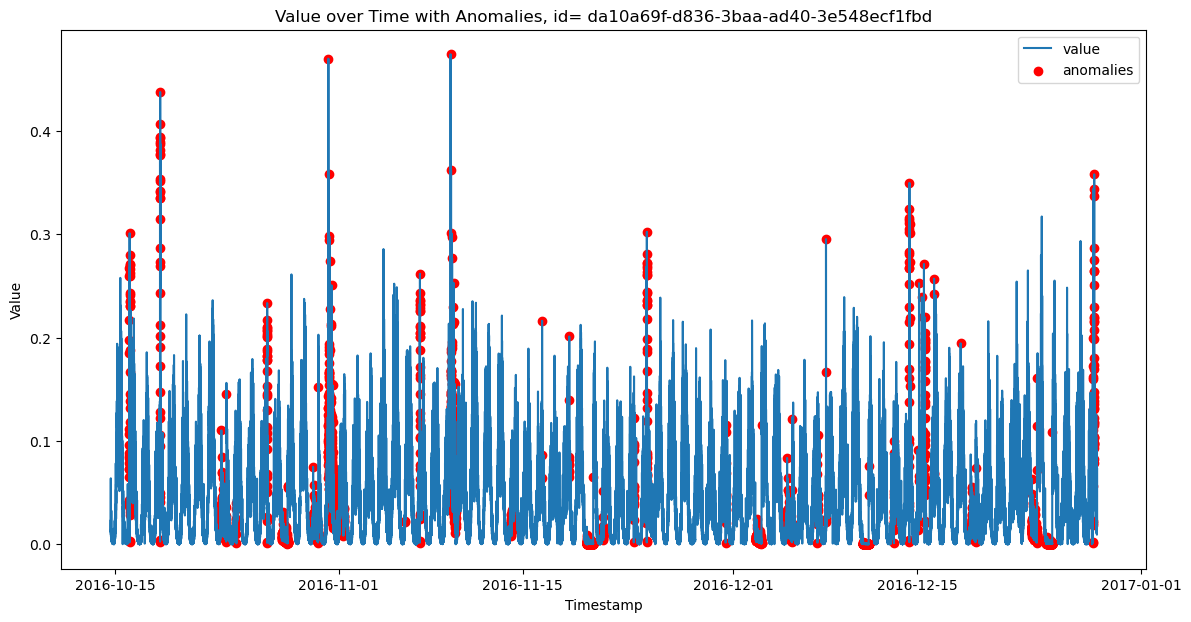

i = e0747cad-8dc8-38a9-a9ab-855b61f5551d


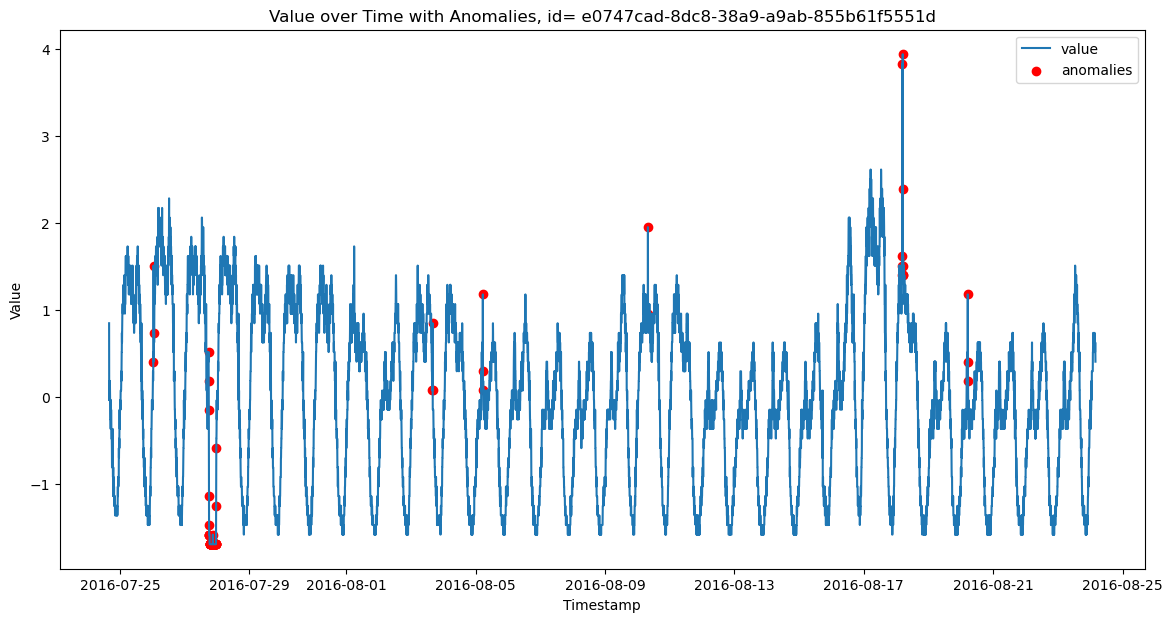

i = ab216663-dcc2-3a24-b1ee-2c3e550e06c9


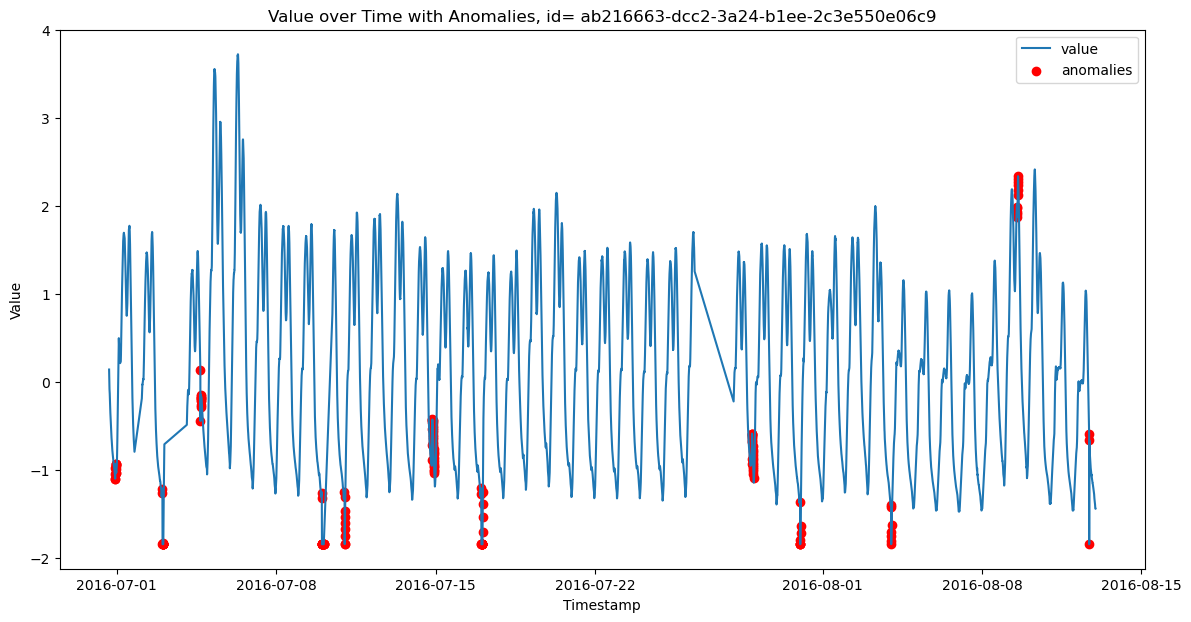

i = 54350a12-7a9d-3ca8-b81f-f886b9d156fd


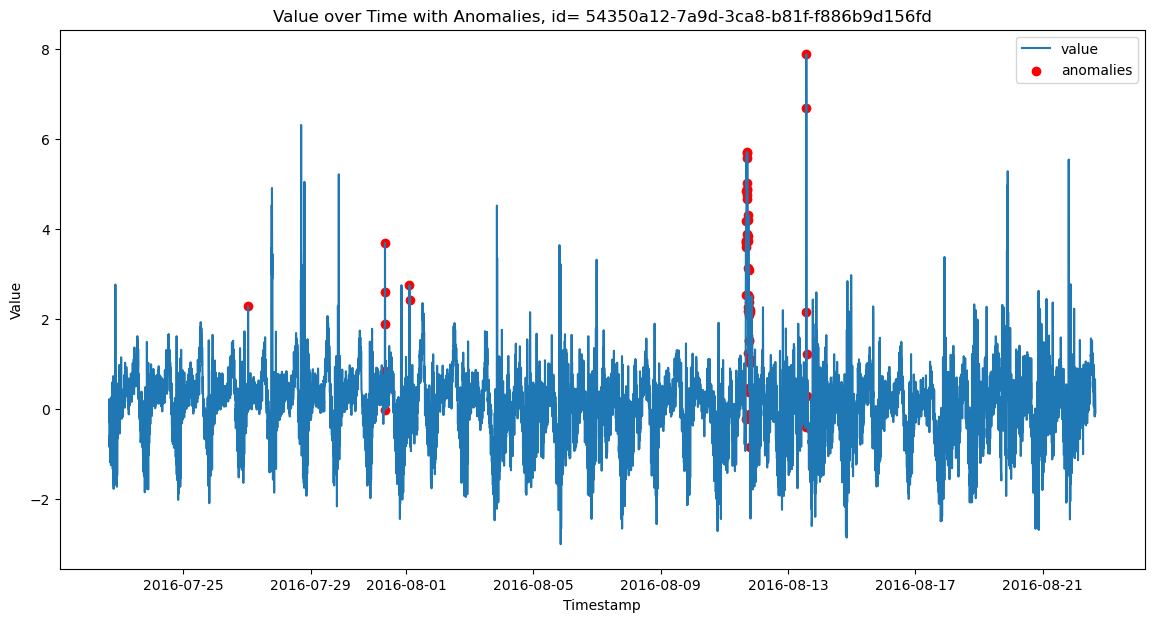

i = a8c06b47-cc41-3738-9110-12df0ee4c721


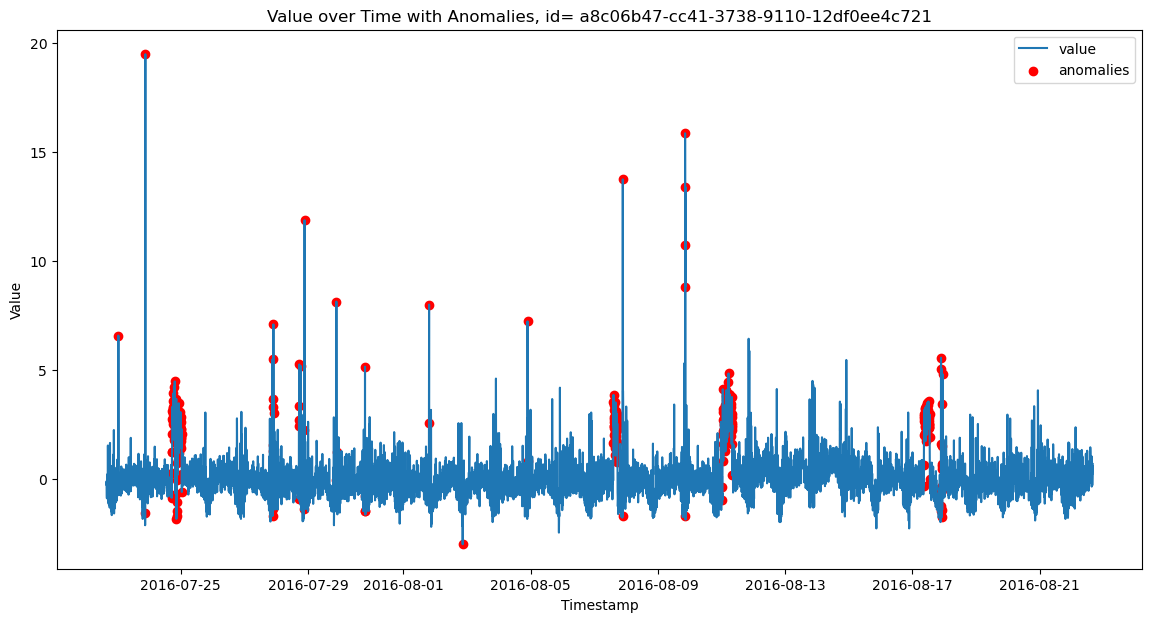

i = 0efb375b-b902-3661-ab23-9a0bb799f4e3


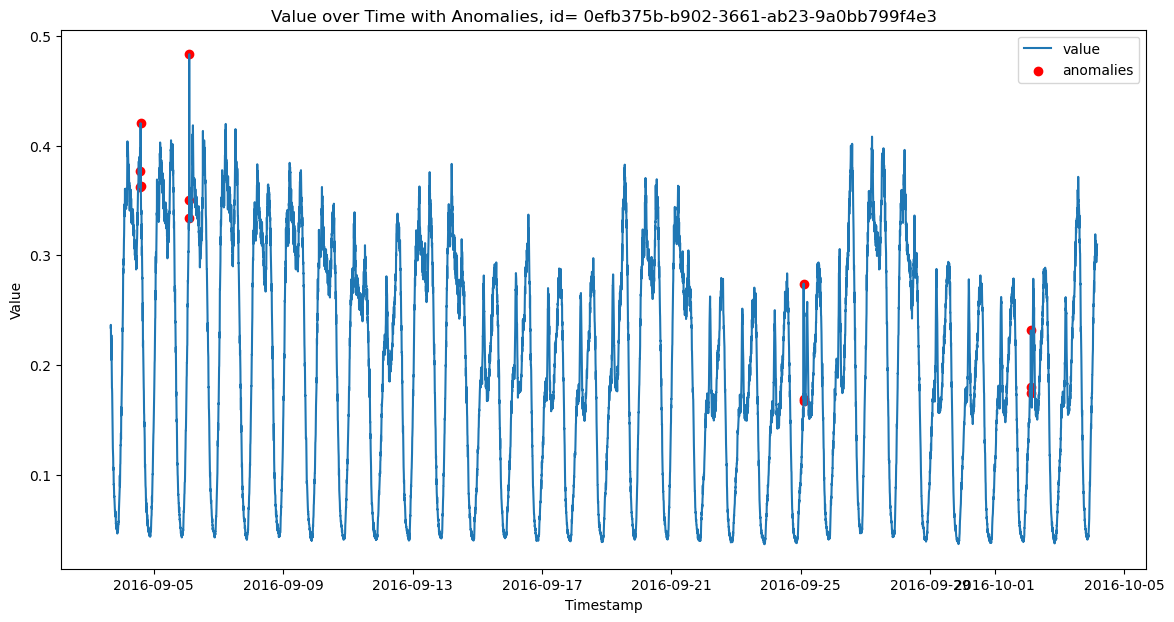

i = c02607e8-7399-3dde-9d28-8a8da5e5d251


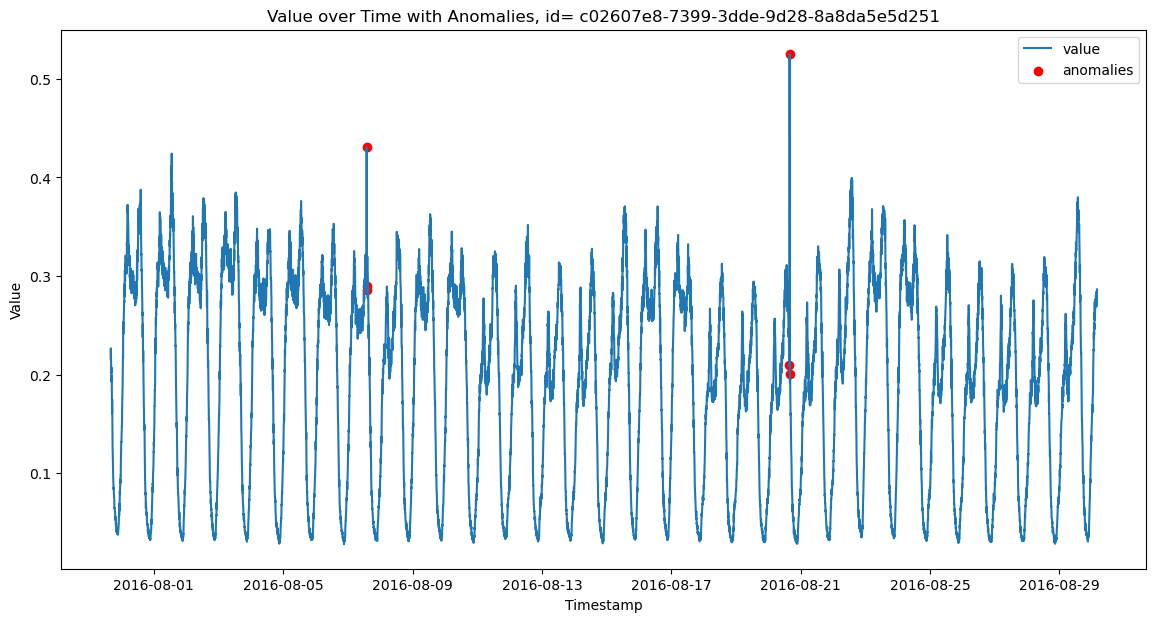

i = 301c70d8-1630-35ac-8f96-bc1b6f4359ea


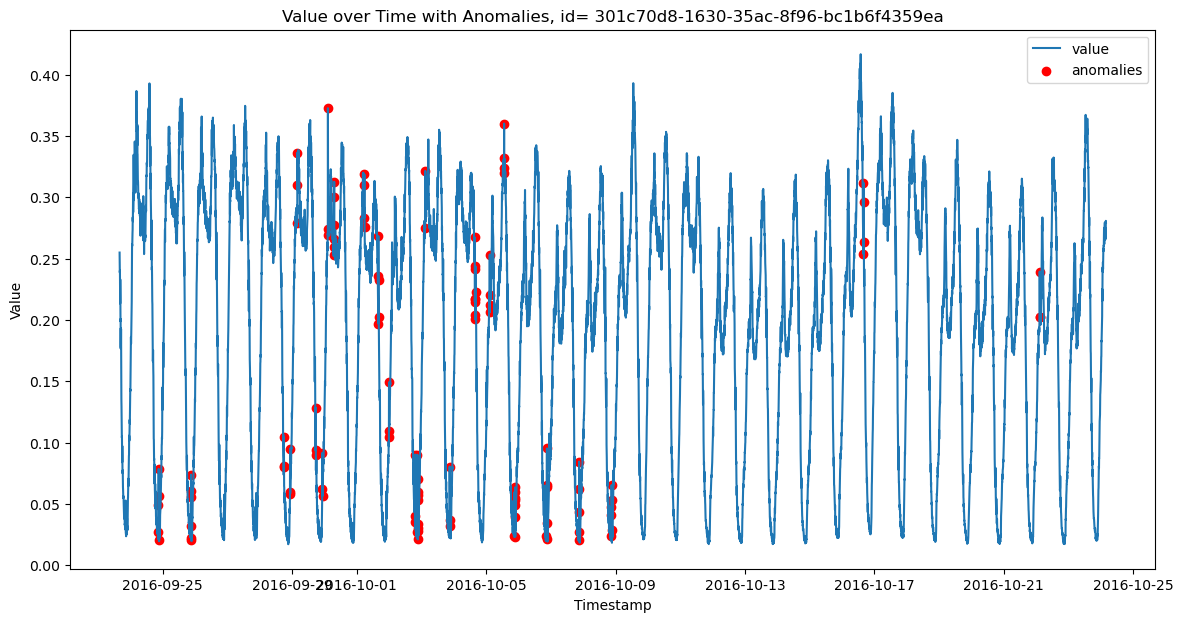

i = 7103fa0f-cac4-314f-addc-866190247439


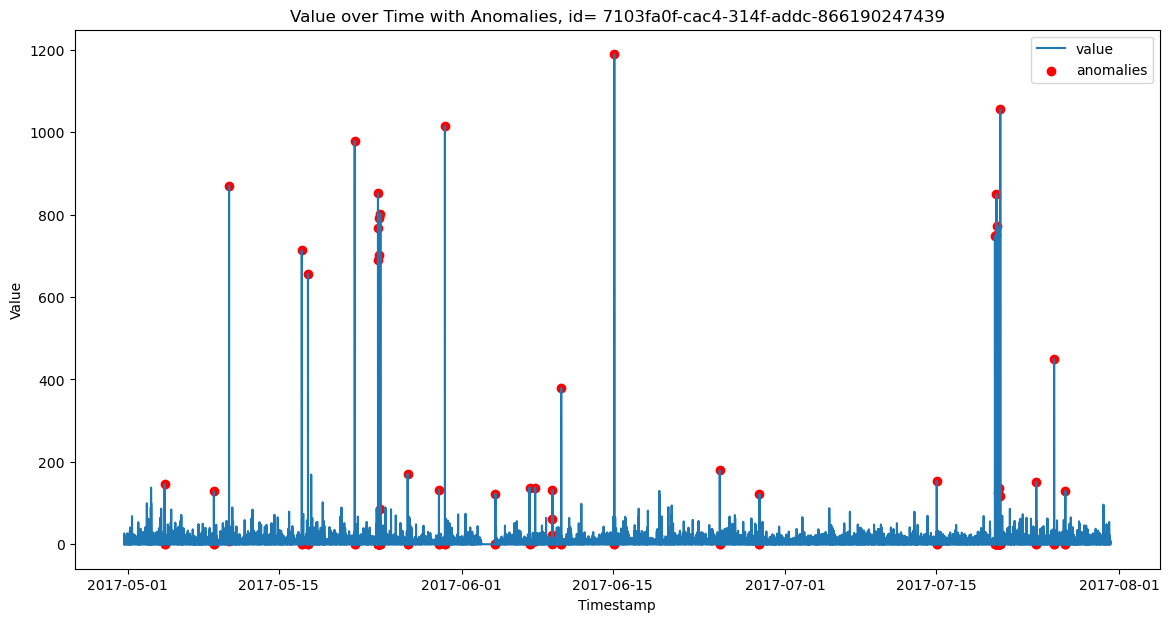

i = 4d2af31a-9916-3d9f-8a8e-8a268a48c095


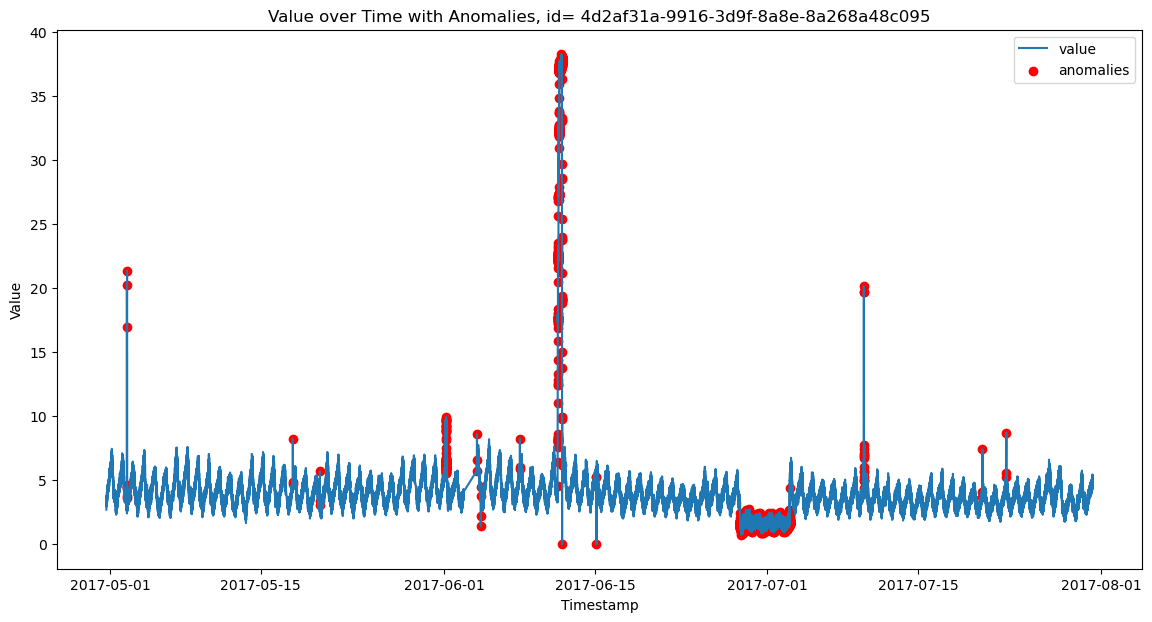

i = 6a757df4-95e5-3357-8406-165e2bd49360


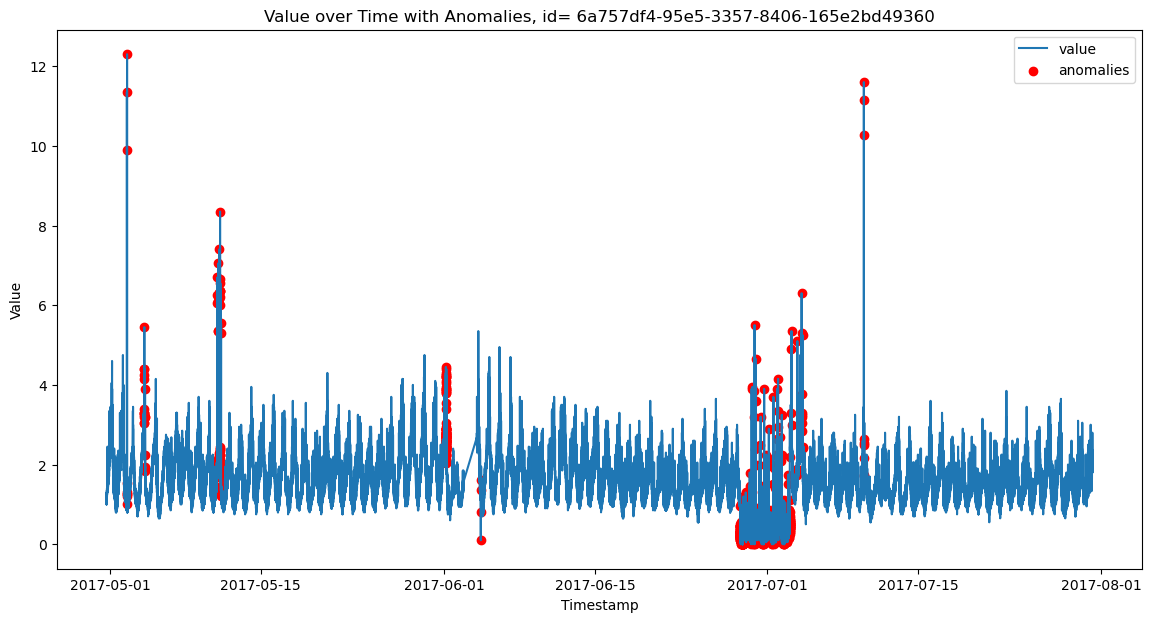

i = ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa


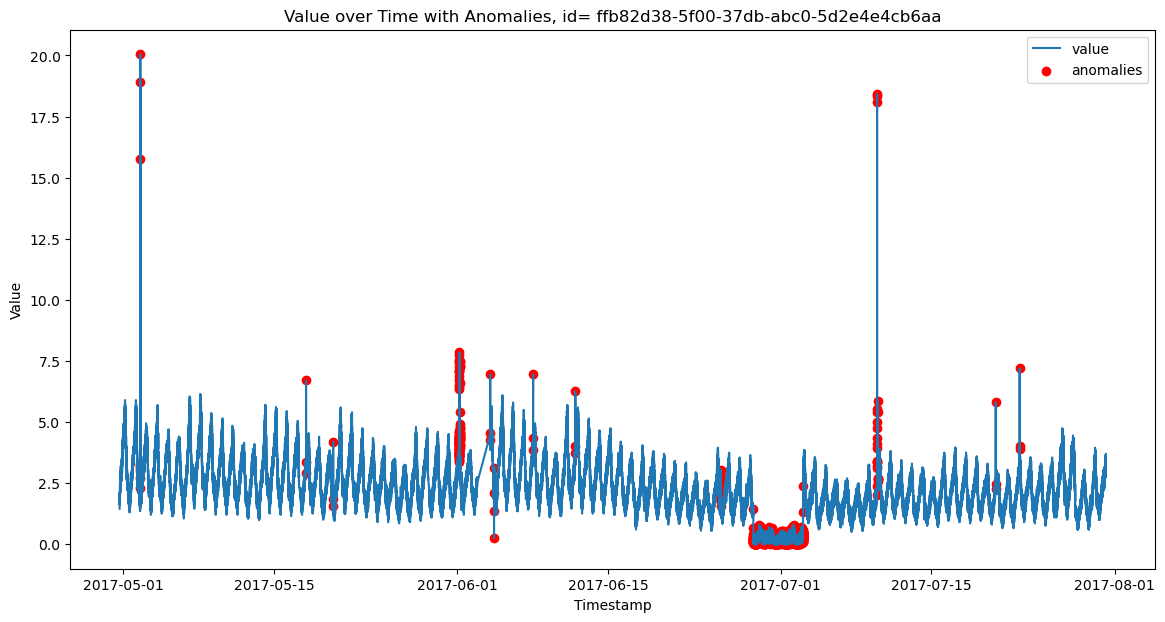

i = 57051487-3a40-3828-9084-a12f7f23ee38


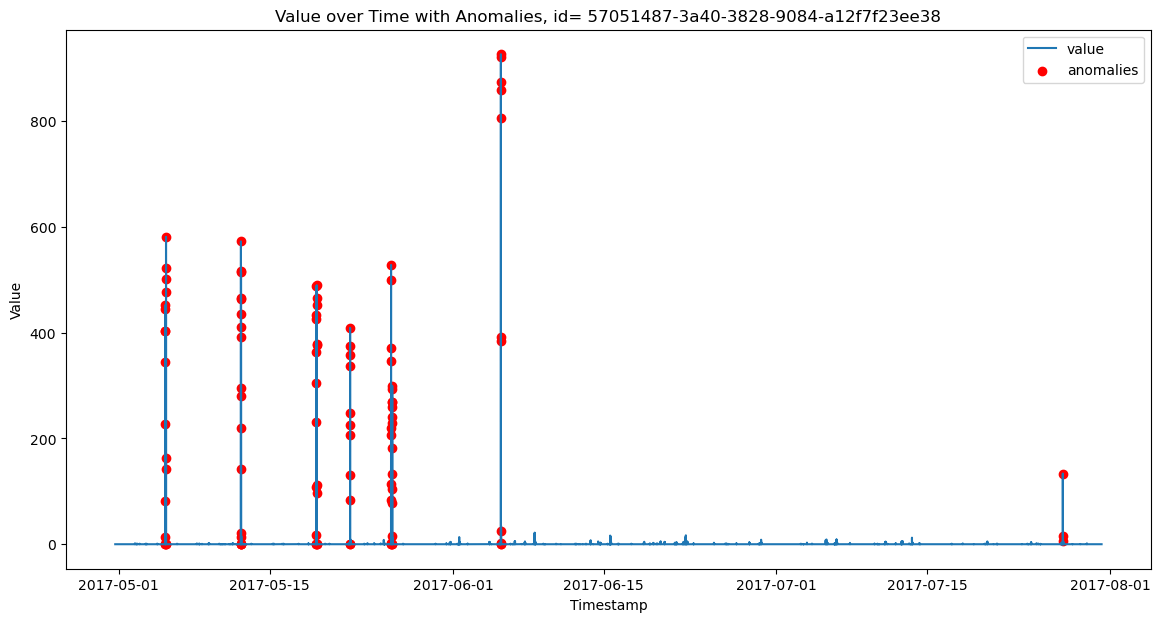

i = f0932edd-6400-3e63-9559-0a9860a1baa9


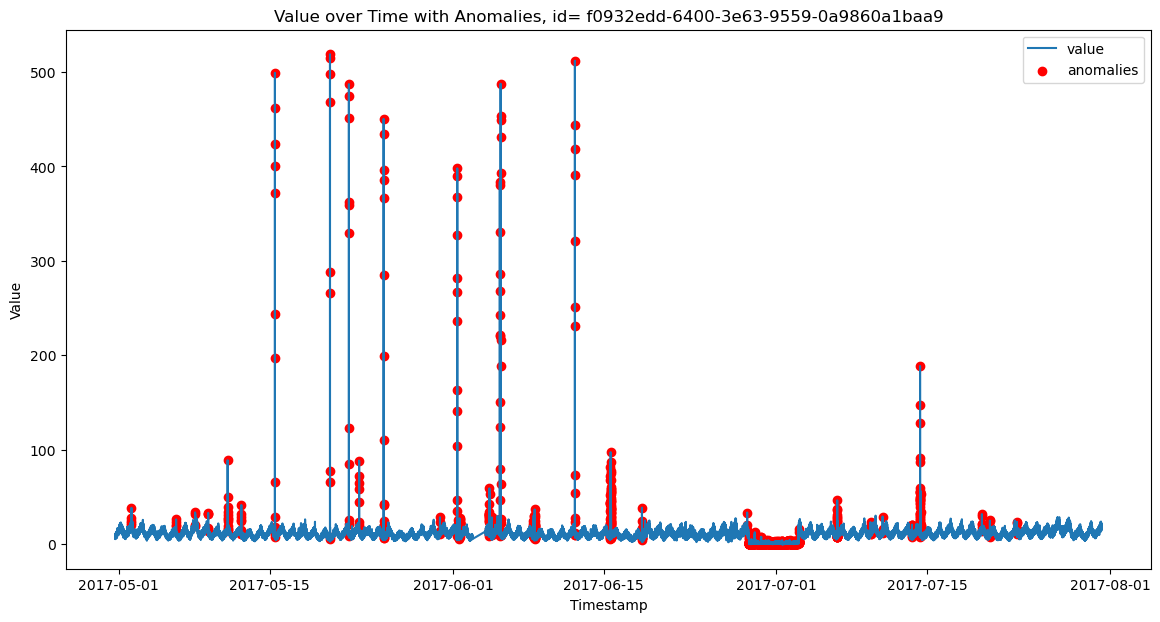

i = 431a8542-c468-3988-a508-3afd06a218da


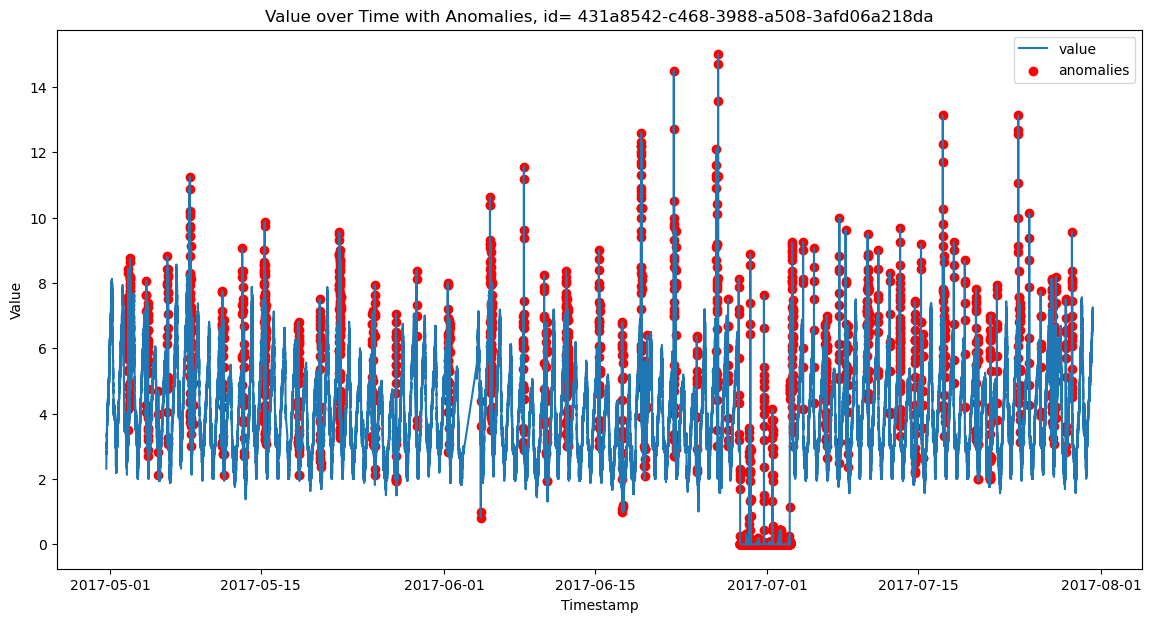

i = 1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0


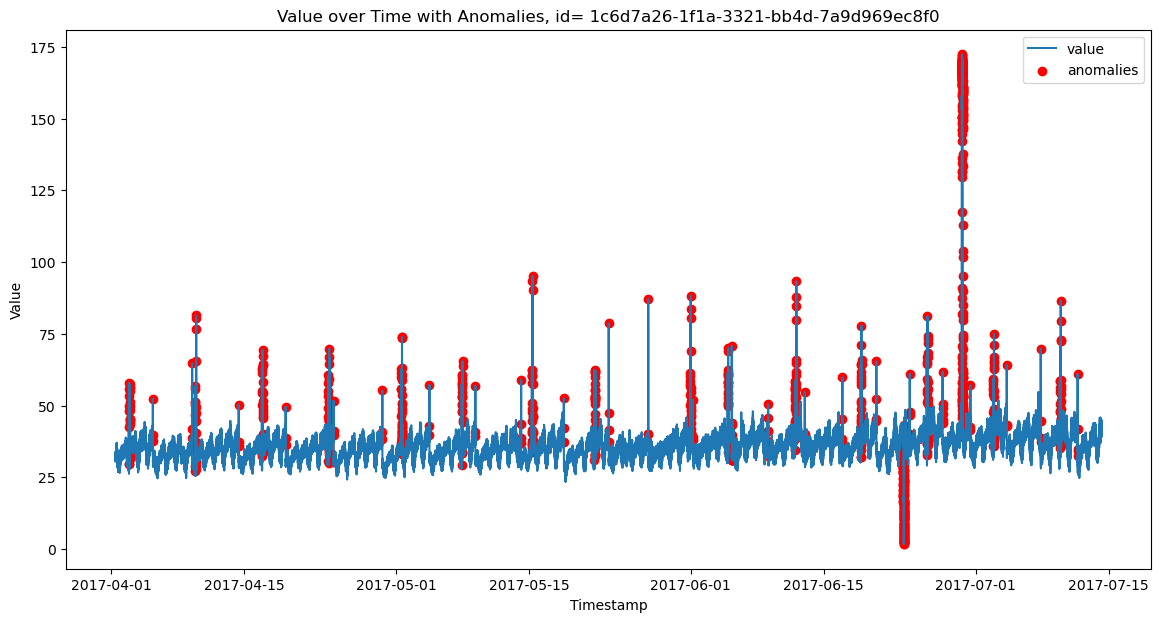

i = c69a50cf-ee03-3bd7-831e-407d36c7ee91


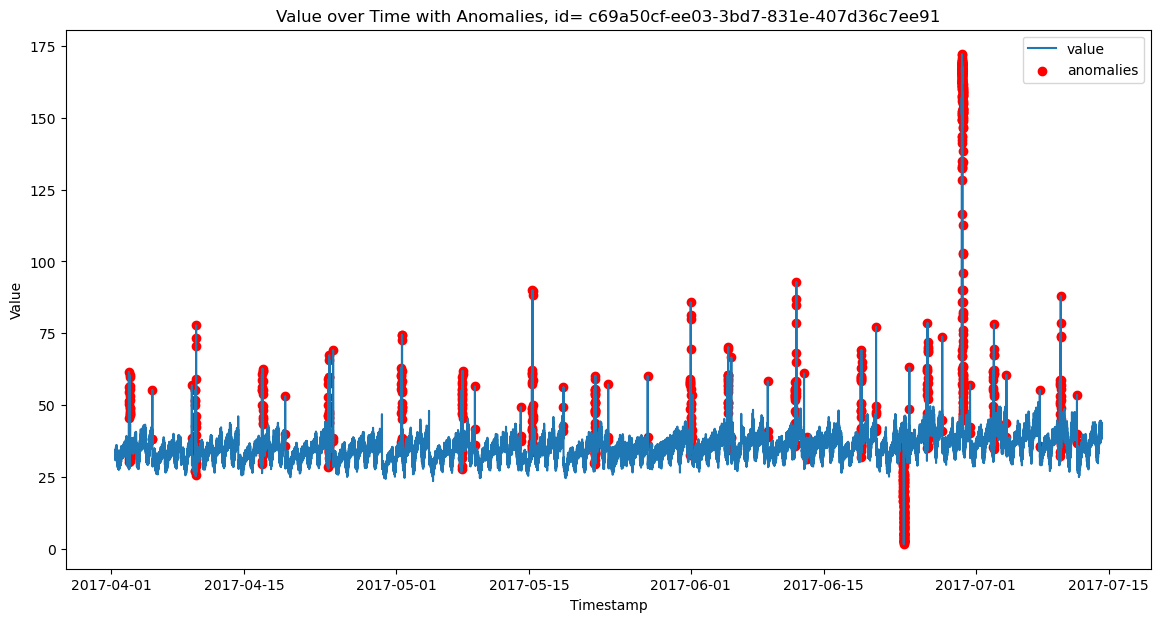

i = 05f10d3a-239c-3bef-9bdc-a2feeb0037aa


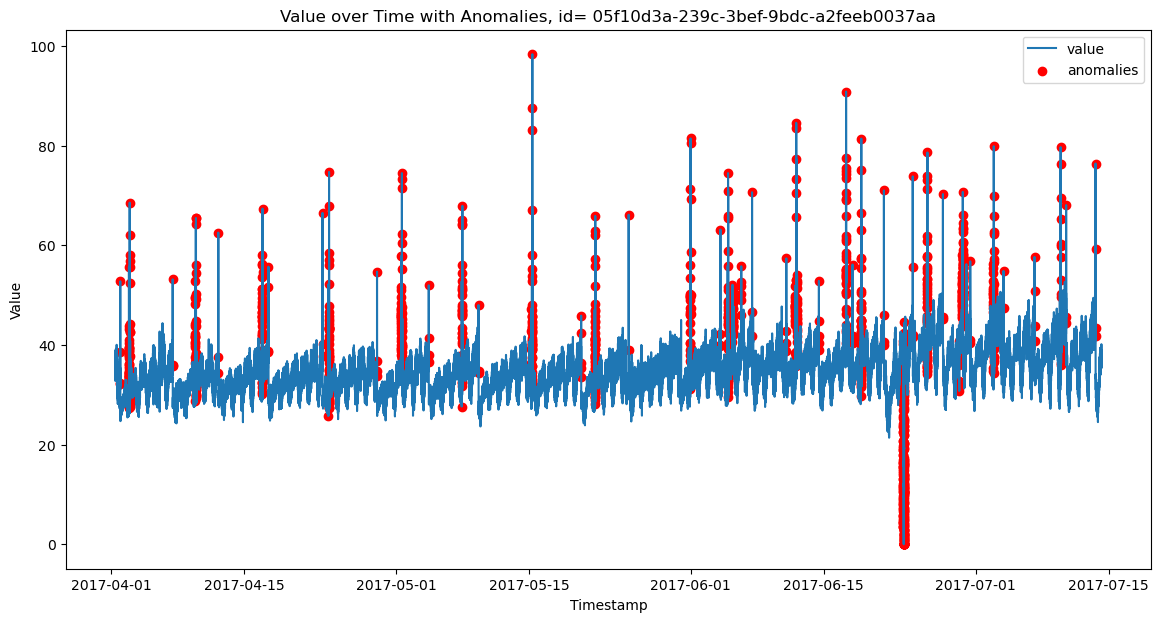

i = 847e8ecc-f8d2-3a93-9107-f367a0aab37d


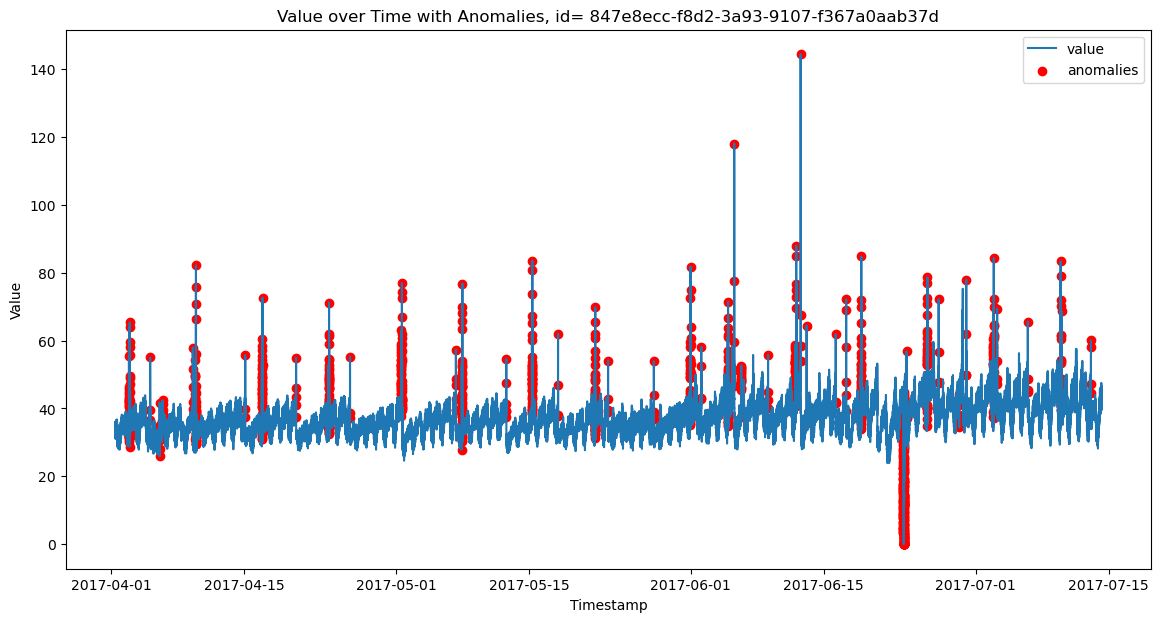

i = 6efa3a07-4544-34a0-b921-a155bd1a05e8


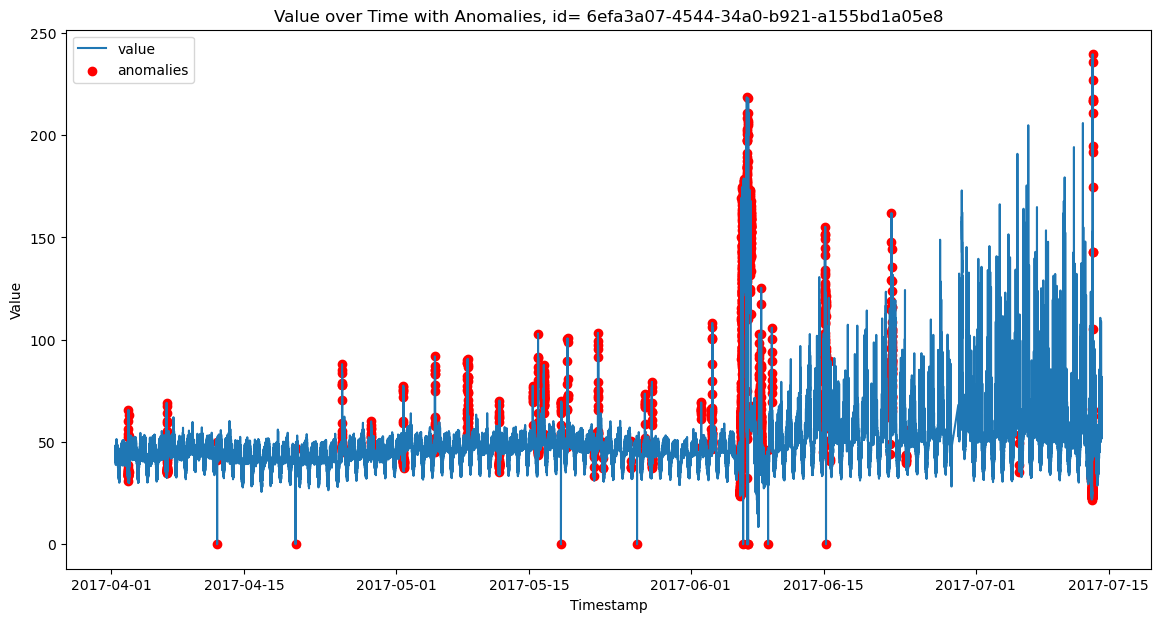

i = 43115f2a-baeb-3b01-96f7-4ea14188343c


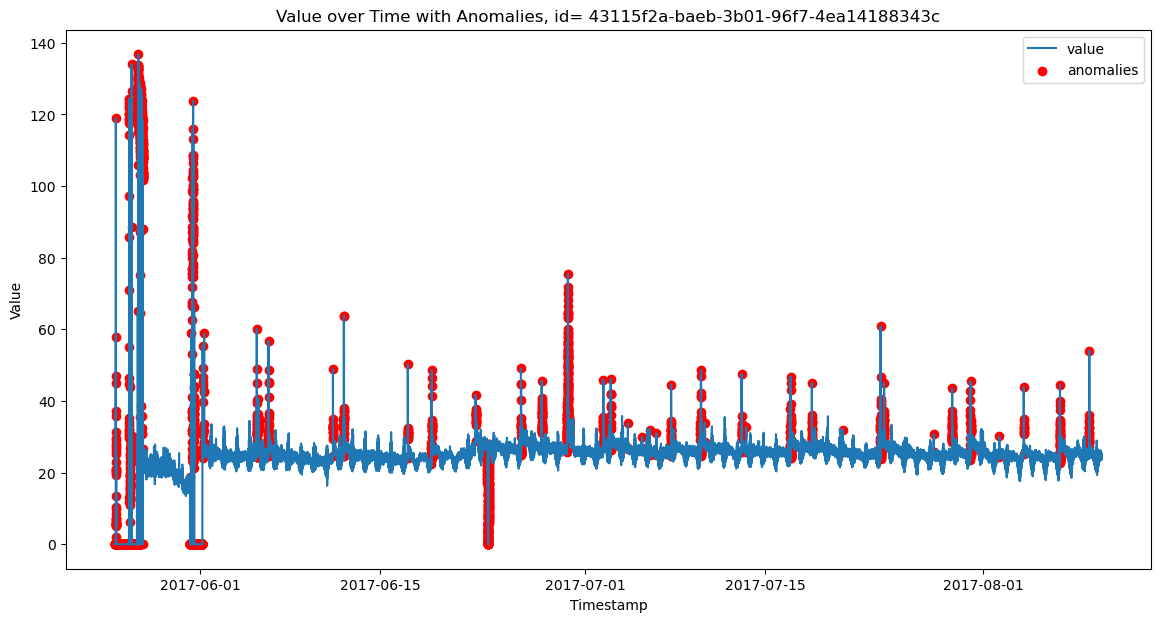

i = 9c639a46-34c8-39bc-aaf0-9144b37adfc8


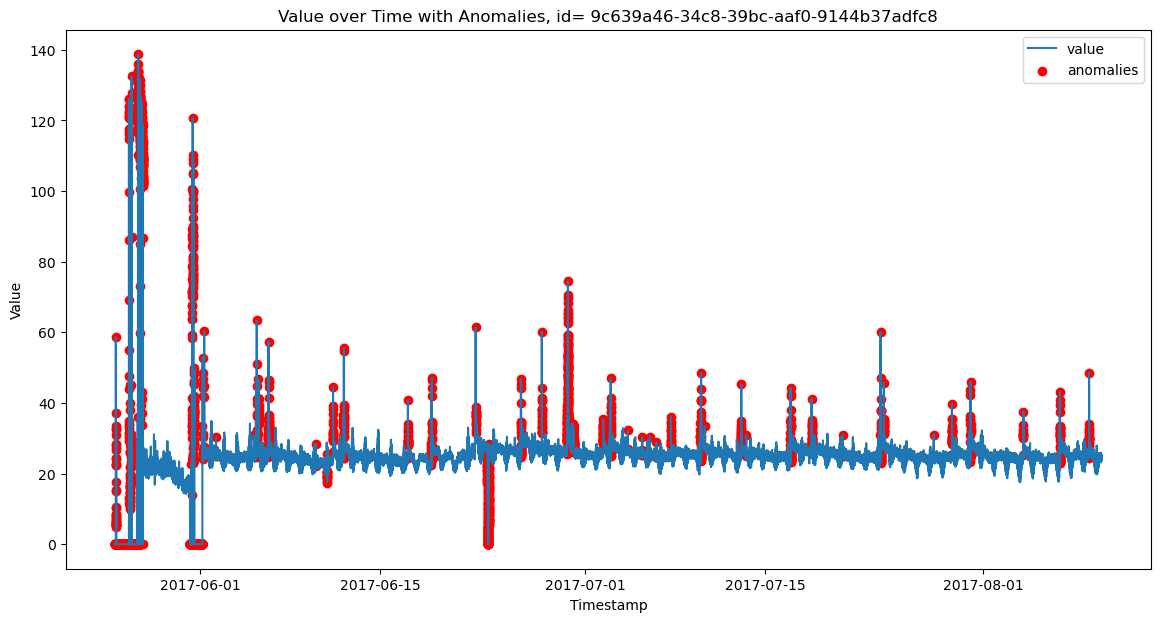

i = a07ac296-de40-3a7c-8df3-91f642cc14d0


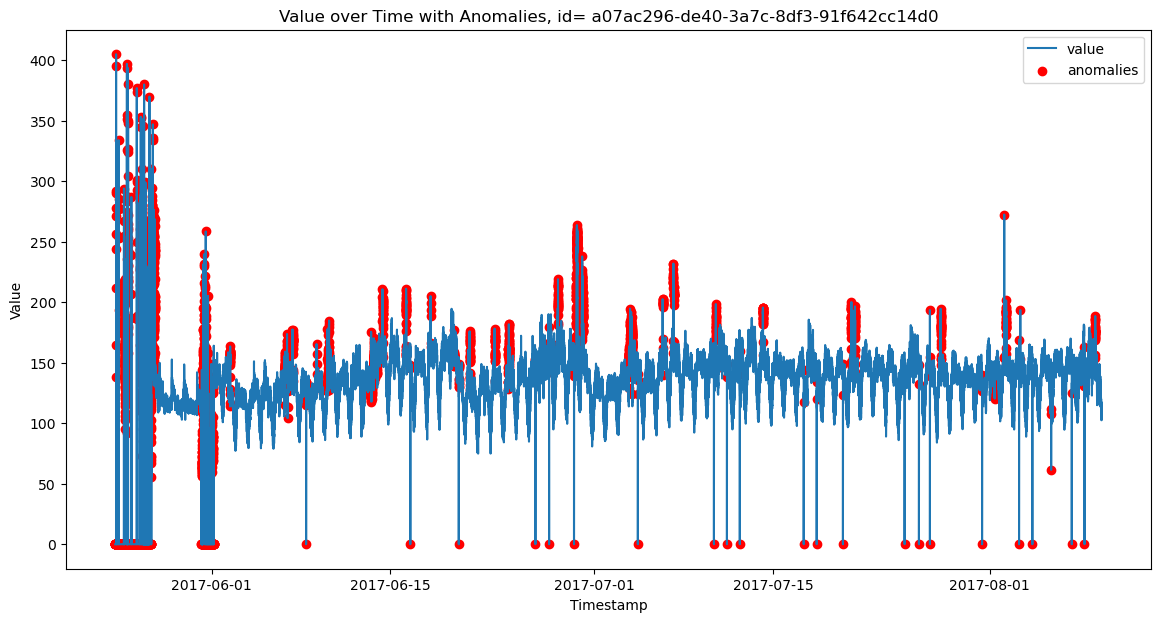

i = ba5f3328-9f3f-3ff5-a683-84437d16d554


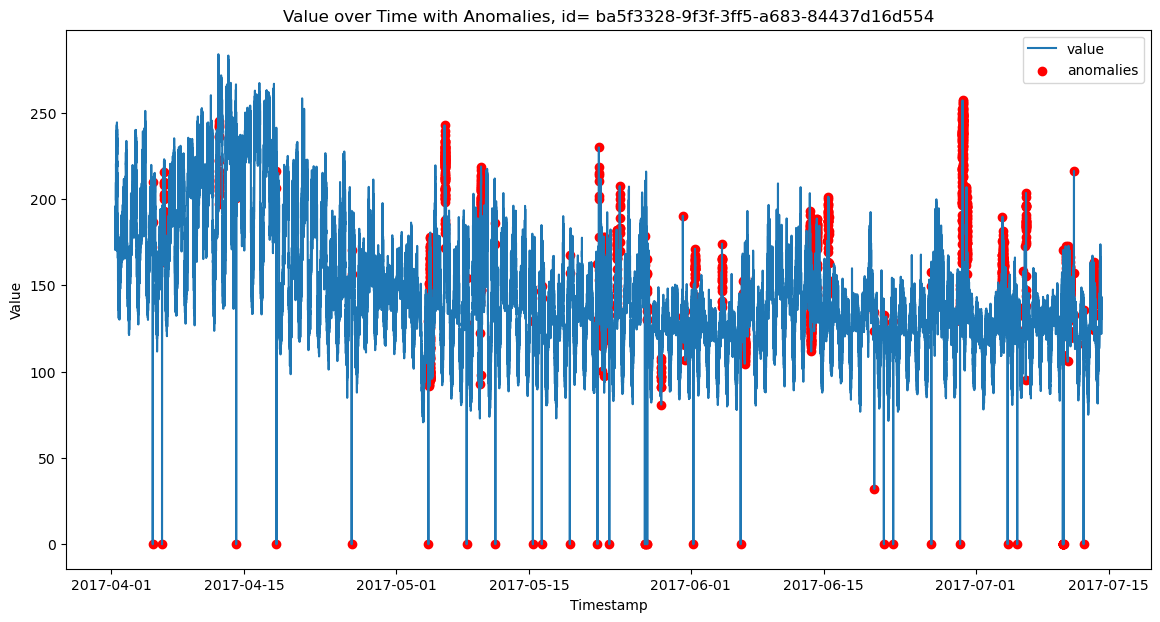

i = 55f8b8b8-b659-38df-b3df-e4a5a8a54bc9


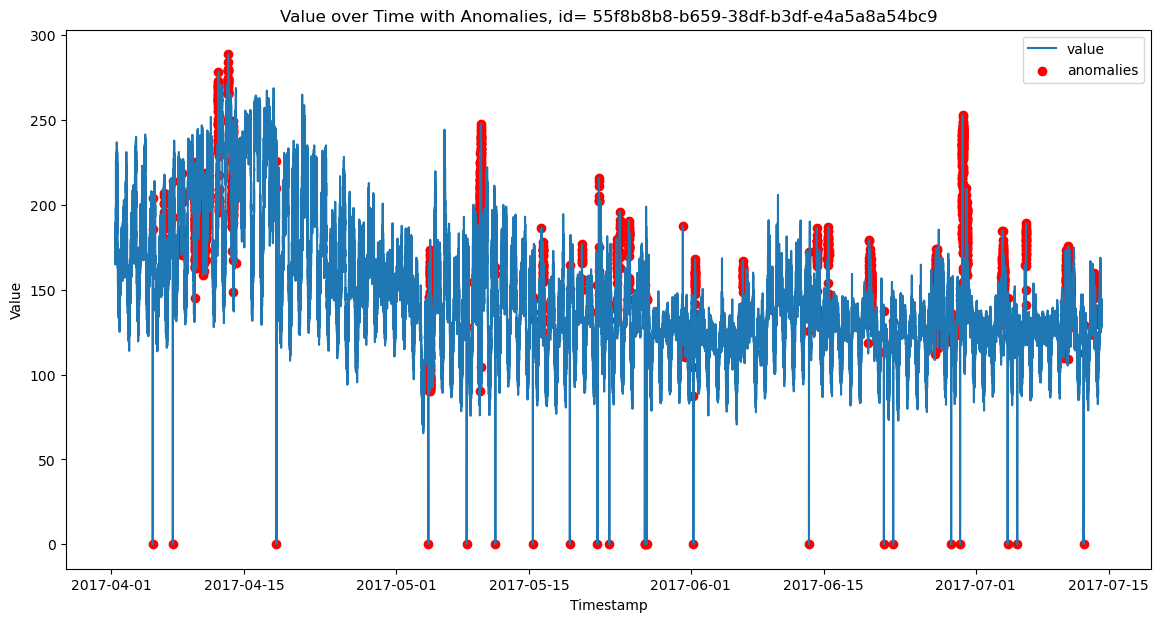

i = 6d1114ae-be04-3c46-b5aa-be1a003a57cd


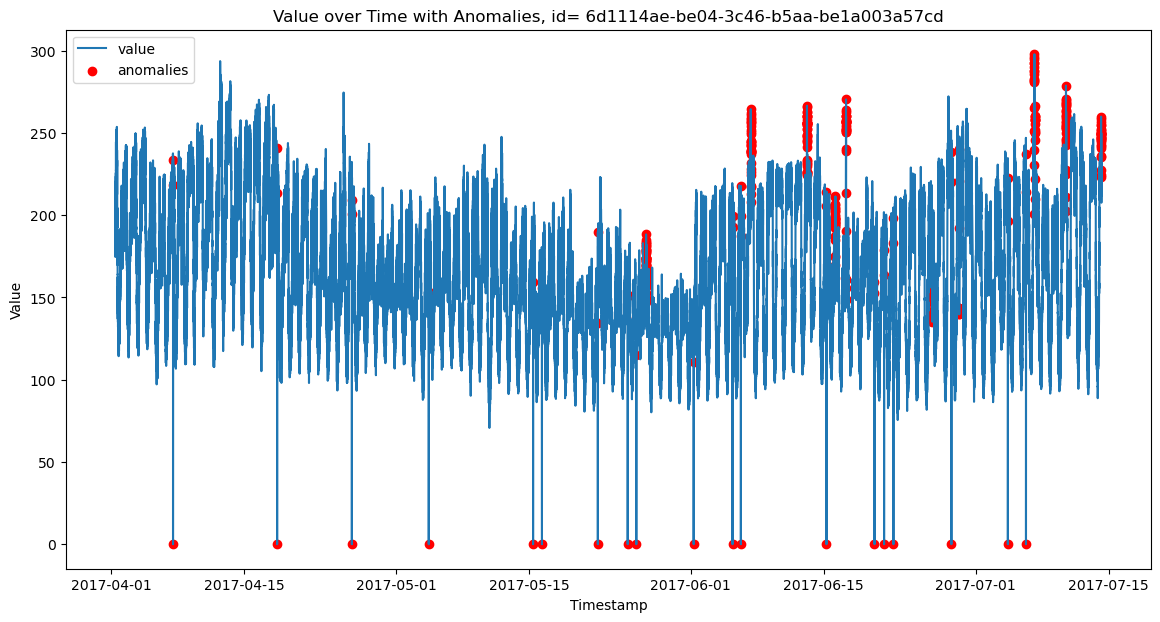

i = 8723f0fb-eaef-32e6-b372-6034c9c04b80


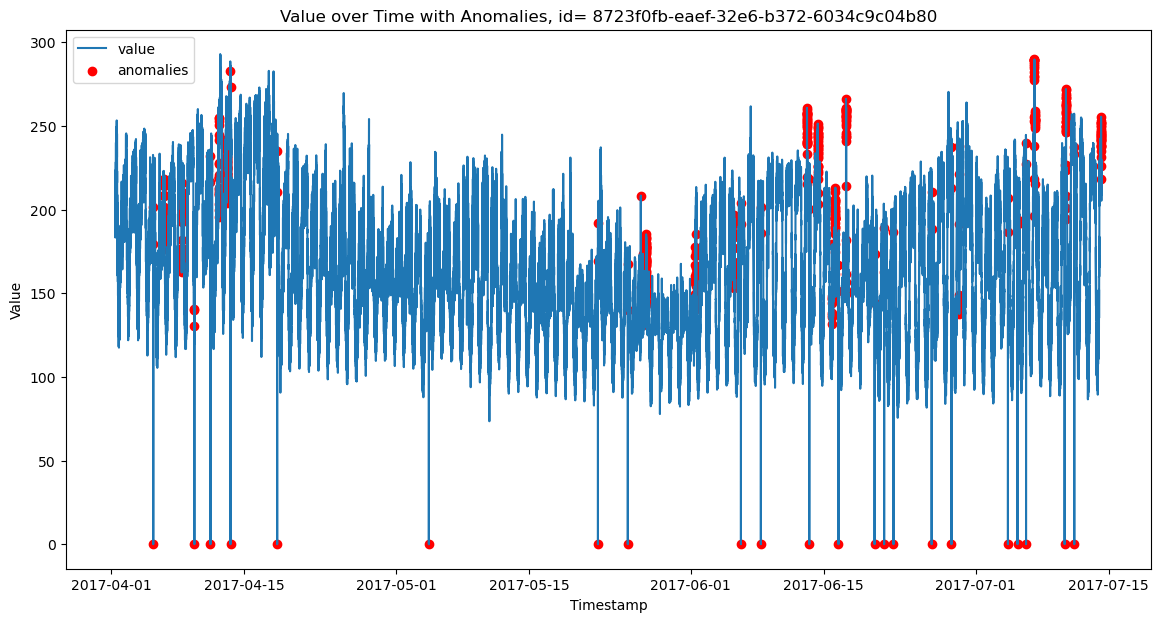

i = adb2fde9-8589-3f5b-a410-5fe14386c7af


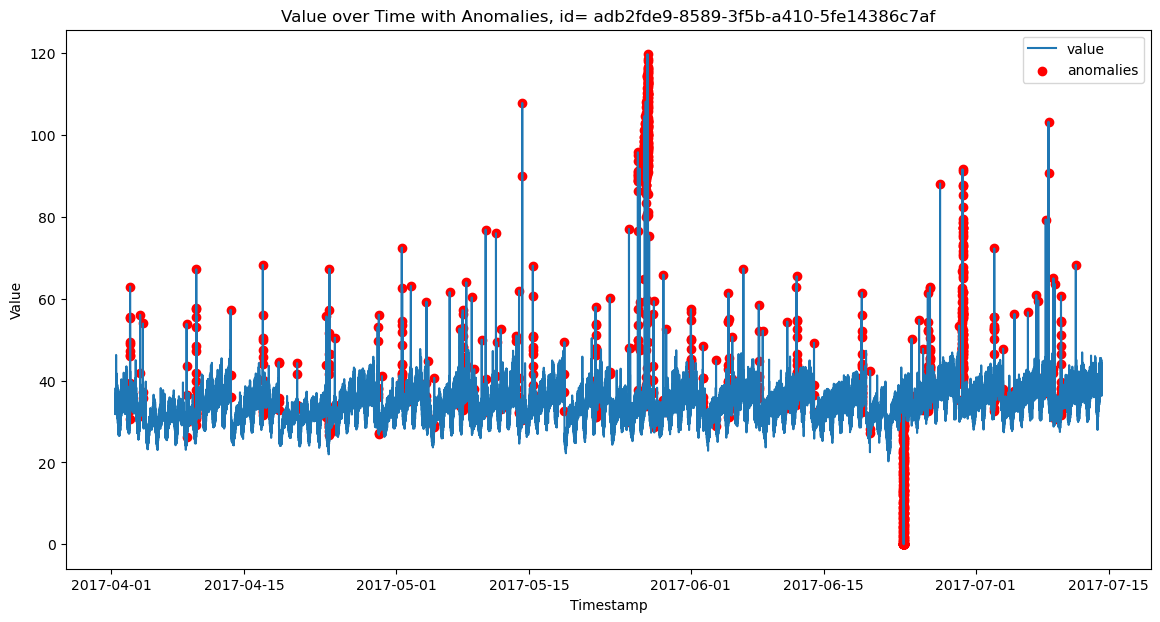

i = 42d6616d-c9c5-370a-a8ba-17ead74f3114


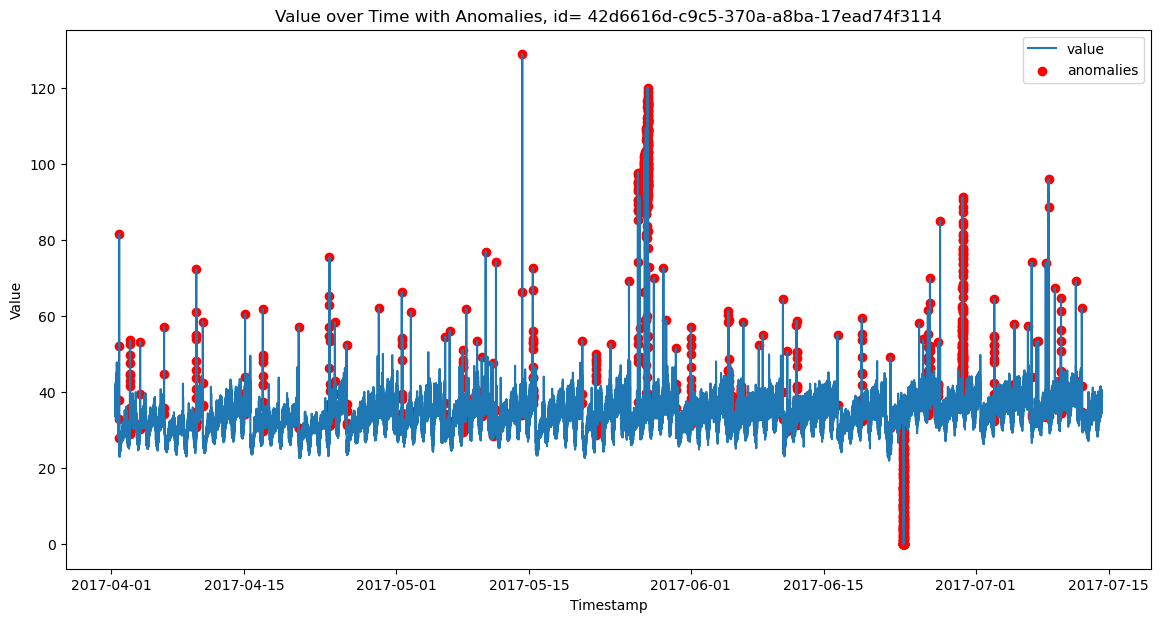

In [5]:
kpi_id_train = train['KPI ID'].unique()
for i in kpi_id_train:
    df = train[train['KPI ID'] == i]
    print(f'i = {i}')
    plt.figure(figsize=(14, 7))

    # Line plot for 'value' over time
    plt.plot(df['timestamp'], df['value'], label='value')

    # Filter out the anomalous points
    anomalies = df[df['label'] == 1]

    # Plot red dots at the anomaly points
    plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='anomalies')

    plt.title(f'Value over Time with Anomalies, id= {i}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

From the charts above we can see that our data consists different types of anomalies: 
* **Point anomalies**. A point anomaly is where a single datapoint stands out from the expected pattern, range, or norm. In other words, the datapoint is unexpected.  
   
* **Collective Anomalies**. A collective anomaly occurs where single datapoints looked at in isolation appear normal. When you look at a group of these datapoints, however, unexpected patterns, behaviours, or results become clear.  
  
   
* **Contextual Anomalies**. Instead of looking at specific datapoints or groups of data, an algorithm looking for contextual anomalies will be interested in unexpected results that come from what appears to be normal activity.The crucial element here is context: Are the results out of context?  
  
More to read: https://hackernoon.com/3-types-of-anomalies-in-anomaly-detection   
https://www.profitana.cz/en/anomaly-detection/

The most interesting charts:

In [ ]:
ok_kpi = ['e0747cad-8dc8-38a9-a9ab-855b61f5551d', '54350a12-7a9d-3ca8-b81f-f886b9d156fd',
          'a8c06b47-cc41-3738-9110-12df0ee4c721', '0efb375b-b902-3661-ab23-9a0bb799f4e3', 
         '301c70d8-1630-35ac-8f96-bc1b6f4359ea', '7103fa0f-cac4-314f-addc-866190247439',
         '57051487-3a40-3828-9084-a12f7f23ee38', 'f0932edd-6400-3e63-9559-0a9860a1baa9',
         '1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0', '05f10d3a-239c-3bef-9bdc-a2feeb0037aa',
         '847e8ecc-f8d2-3a93-9107-f367a0aab37d', 'a07ac296-de40-3a7c-8df3-91f642cc14d0',
         '55f8b8b8-b659-38df-b3df-e4a5a8a54bc9', 'adb2fde9-8589-3f5b-a410-5fe14386c7af']

#### Test part

In [30]:
labels = pd.read_hdf('iot_dataset/phase2_ground_truth.hdf')
labels['timestamp'] = pd.to_datetime(labels['timestamp'], unit='s')
labels['KPI ID'] = labels['KPI ID'].astype(str)

In [6]:
labels.head()

timestamp     value  label  \
107717 2016-12-28 16:00:00  0.048066      0   
107718 2016-12-28 16:01:00  0.010651      0   
107719 2016-12-28 16:02:00  0.014996      0   
107720 2016-12-28 16:03:00  0.039722      0   
107721 2016-12-28 16:04:00  0.022452      0   

                                      KPI ID  
107717  da10a69f-d836-3baa-ad40-3e548ecf1fbd  
107718  da10a69f-d836-3baa-ad40-3e548ecf1fbd  
107719  da10a69f-d836-3baa-ad40-3e548ecf1fbd  
107720  da10a69f-d836-3baa-ad40-3e548ecf1fbd  
107721  da10a69f-d836-3baa-ad40-3e548ecf1fbd

i = da10a69f-d836-3baa-ad40-3e548ecf1fbd


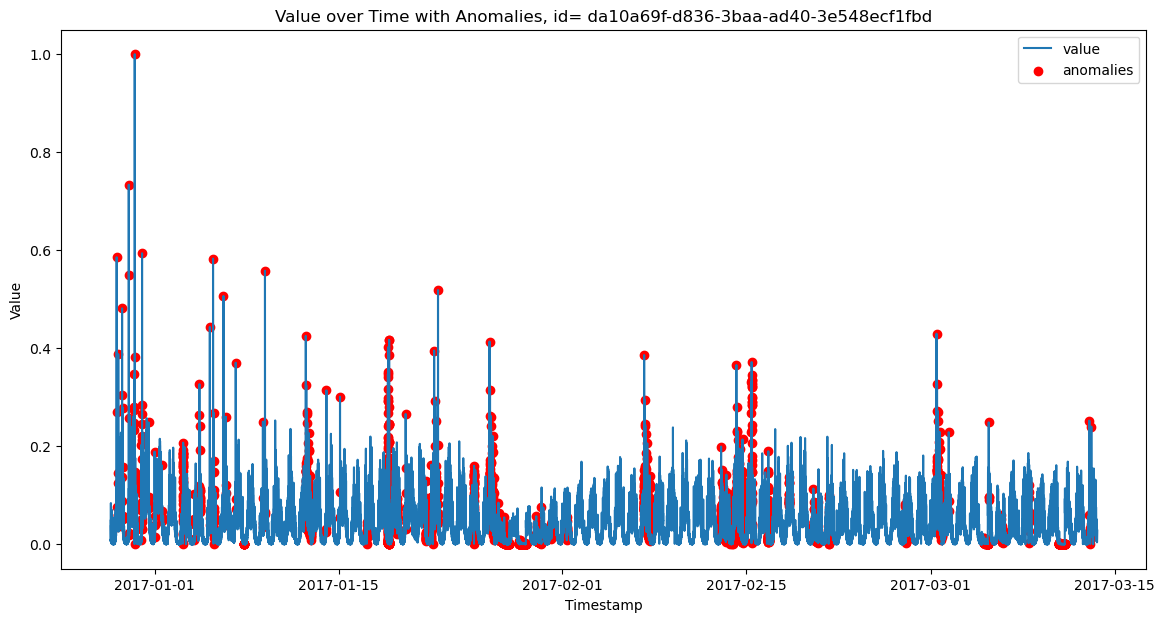

i = e0747cad-8dc8-38a9-a9ab-855b61f5551d


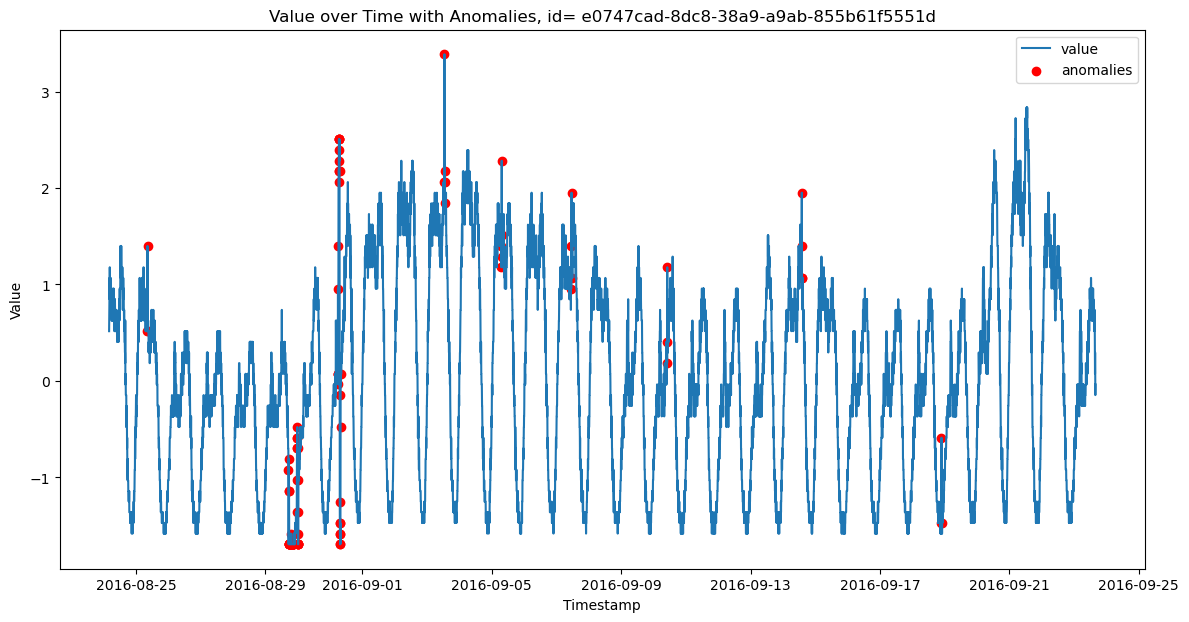

i = ab216663-dcc2-3a24-b1ee-2c3e550e06c9


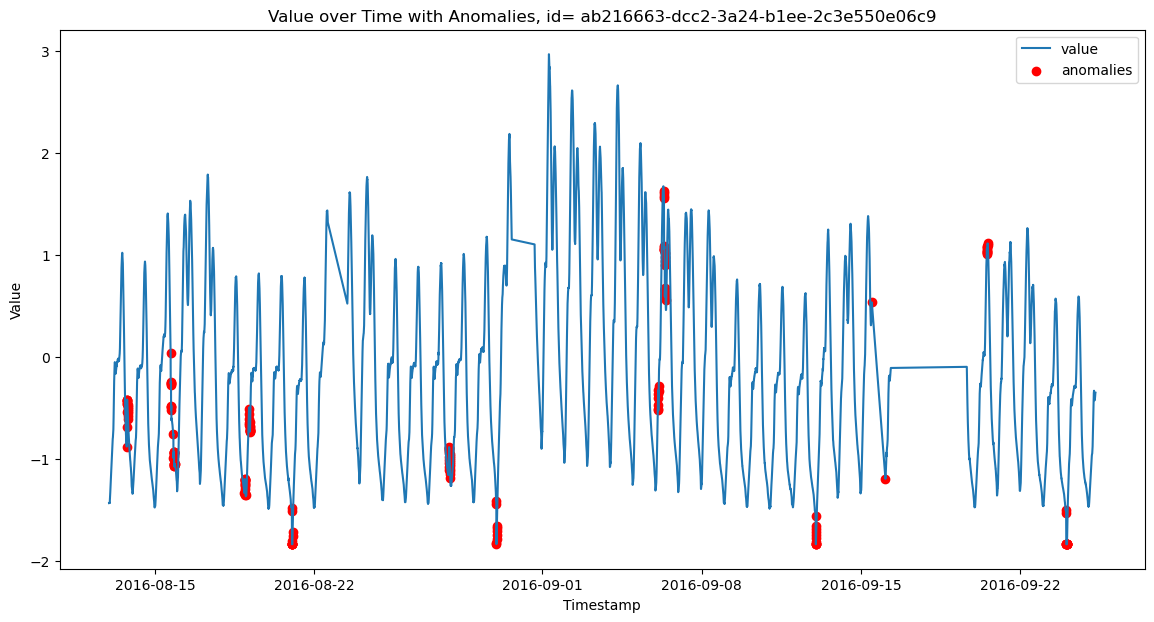

i = 54350a12-7a9d-3ca8-b81f-f886b9d156fd


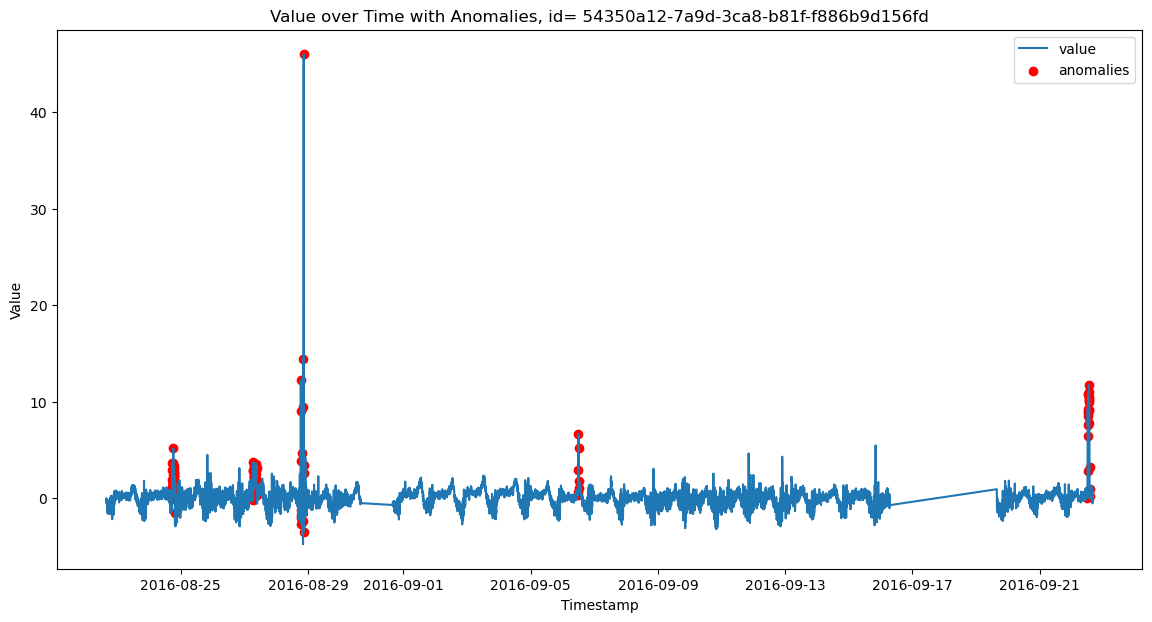

i = a8c06b47-cc41-3738-9110-12df0ee4c721


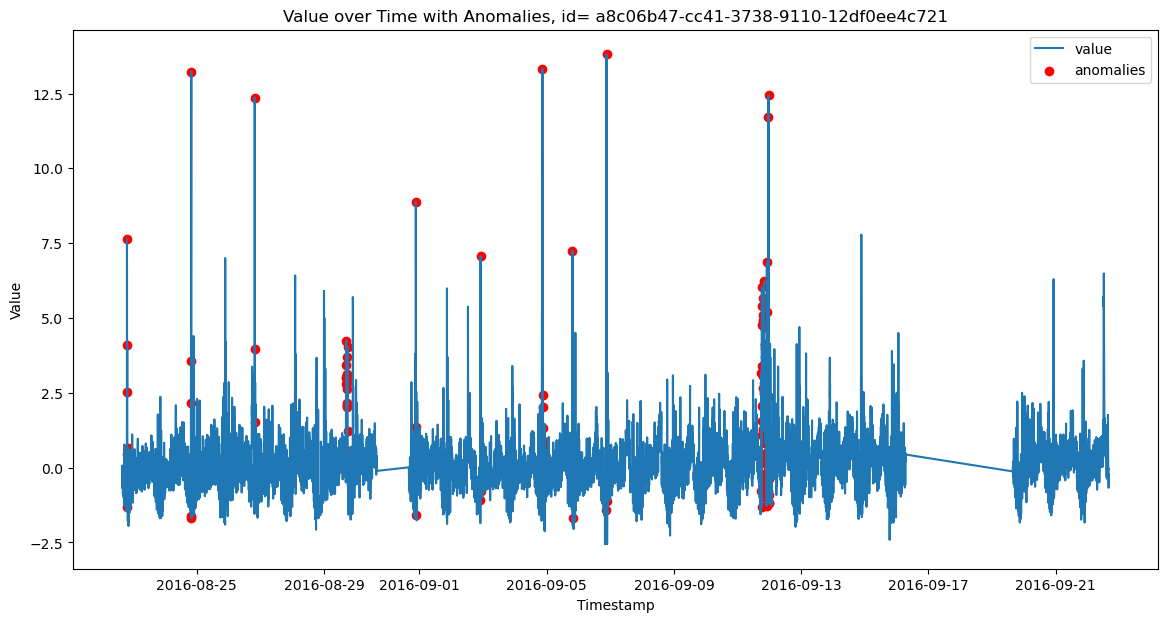

i = 0efb375b-b902-3661-ab23-9a0bb799f4e3


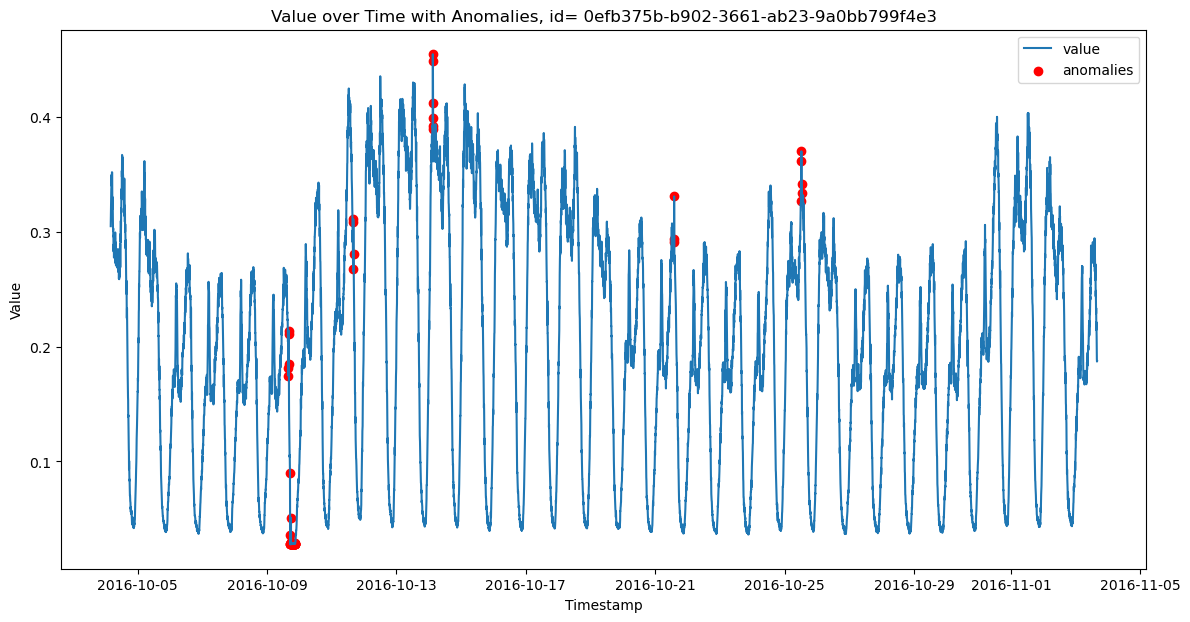

i = c02607e8-7399-3dde-9d28-8a8da5e5d251


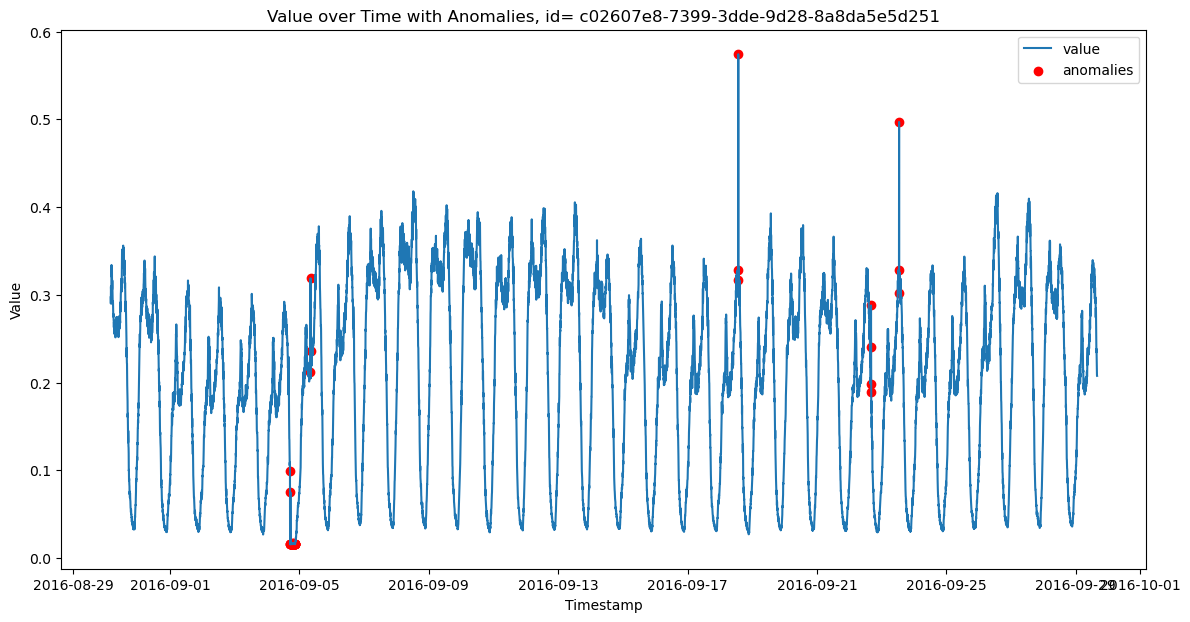

i = 301c70d8-1630-35ac-8f96-bc1b6f4359ea


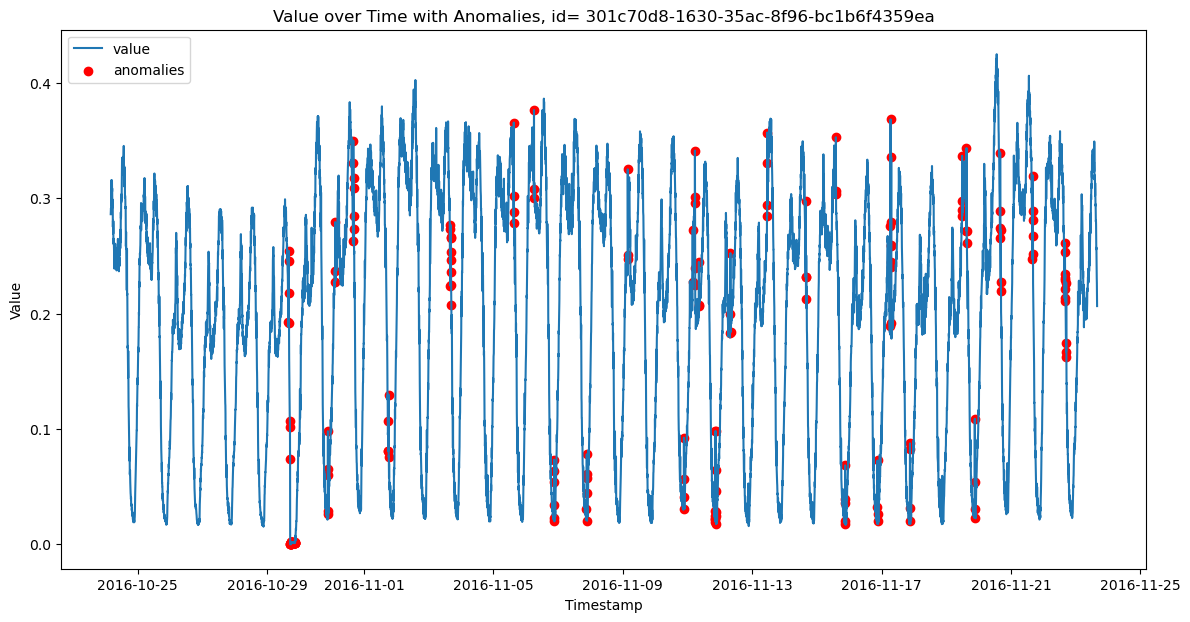

i = 7103fa0f-cac4-314f-addc-866190247439


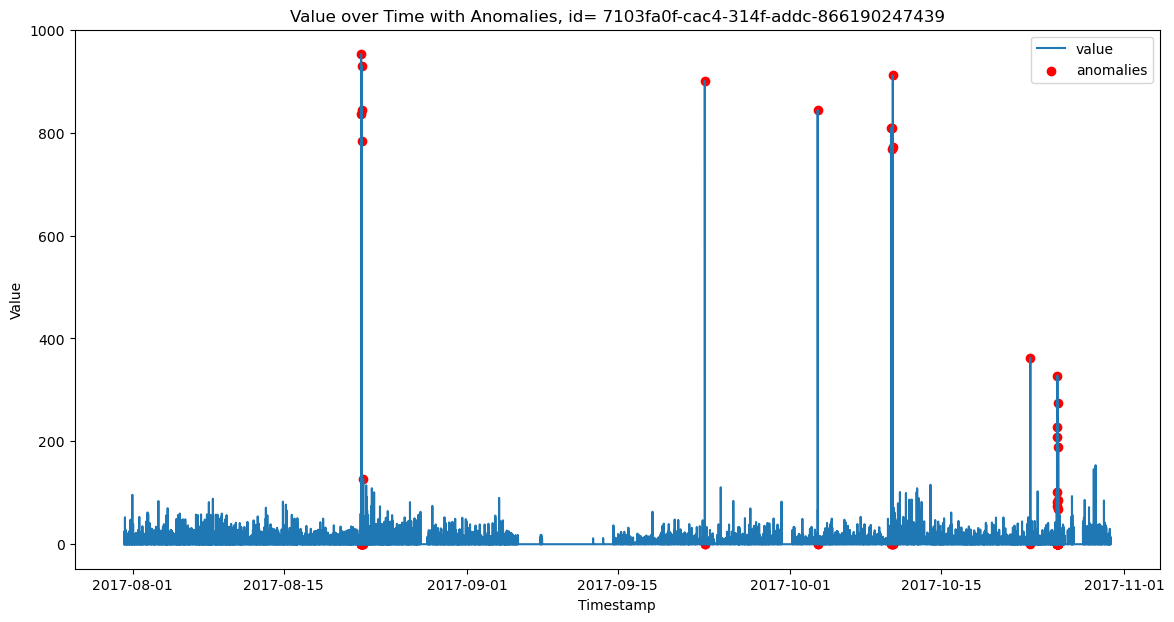

i = 4d2af31a-9916-3d9f-8a8e-8a268a48c095


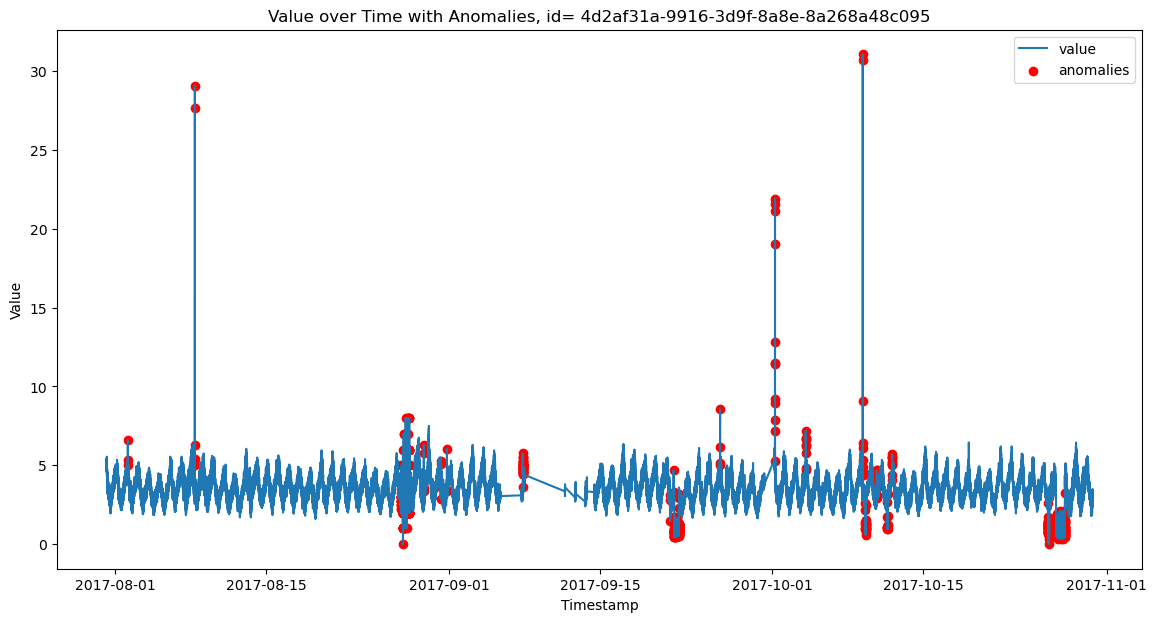

i = 6a757df4-95e5-3357-8406-165e2bd49360


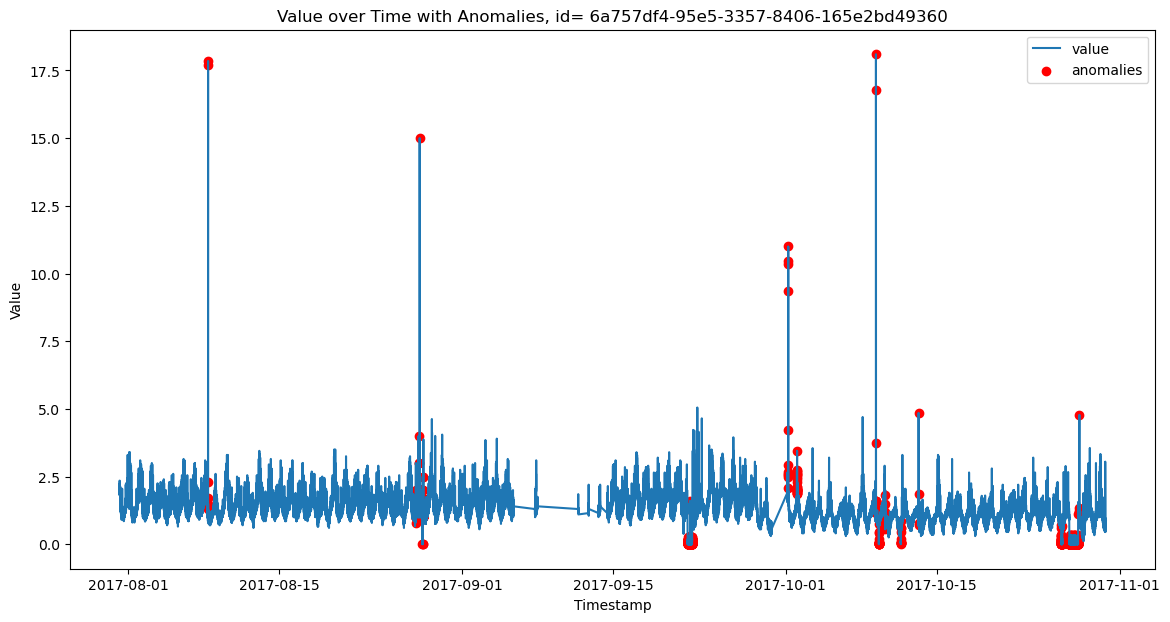

i = ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa


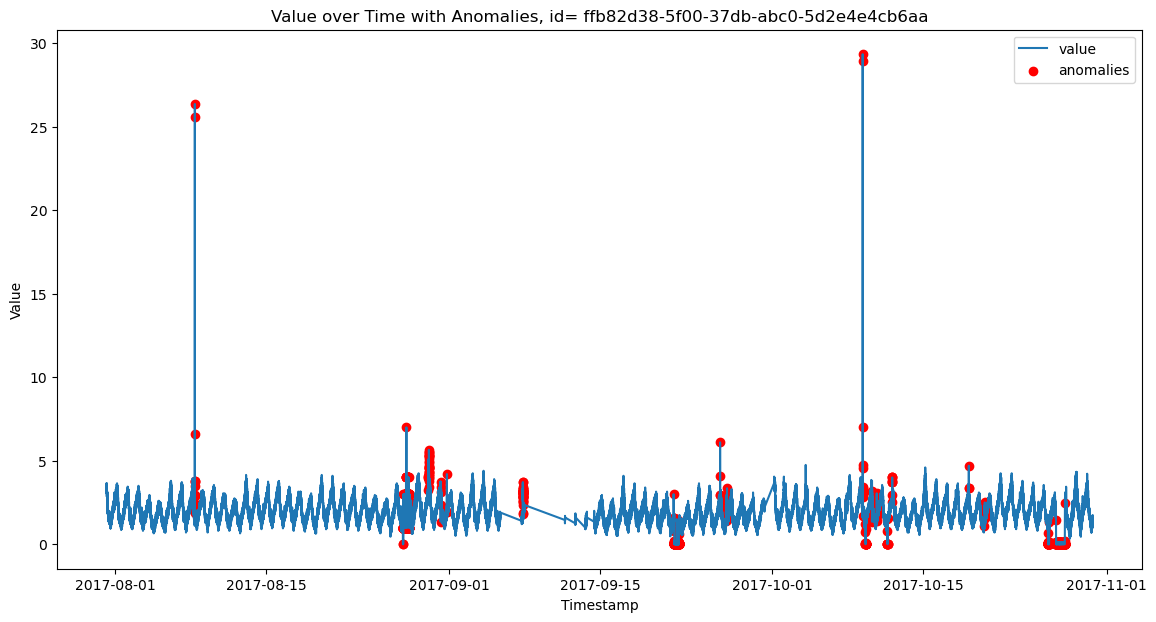

i = 57051487-3a40-3828-9084-a12f7f23ee38


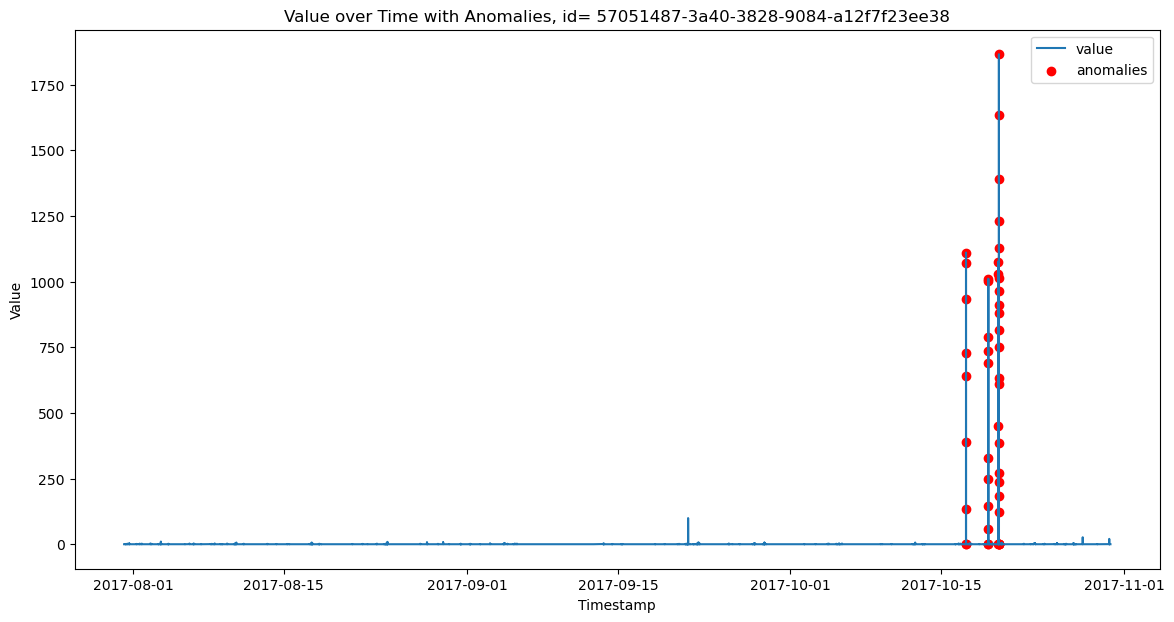

i = f0932edd-6400-3e63-9559-0a9860a1baa9


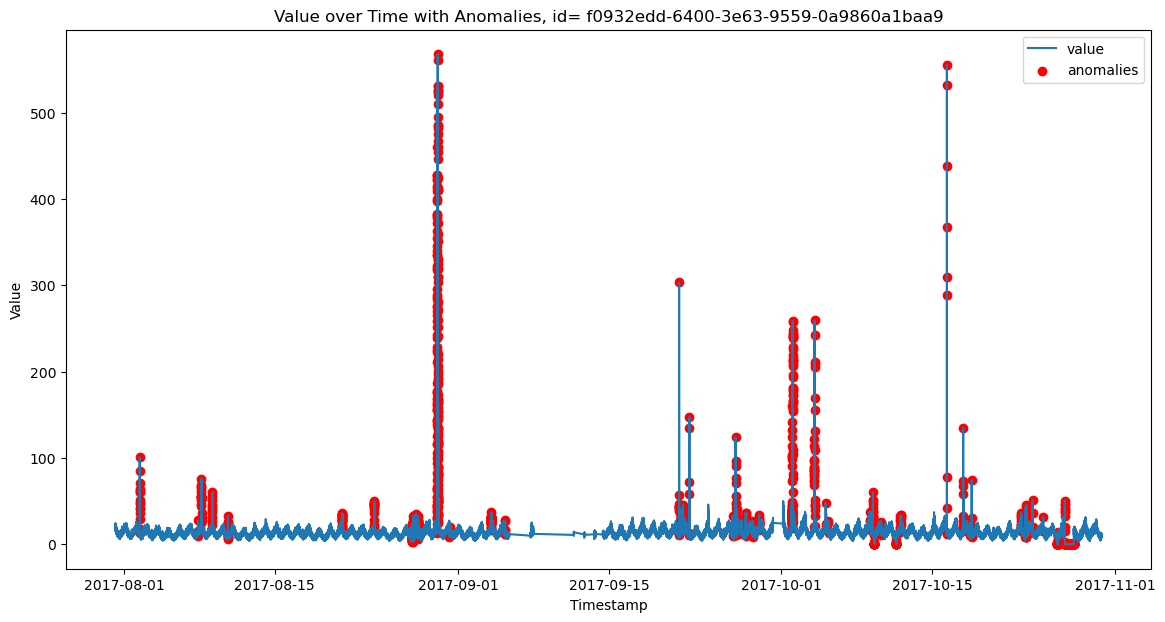

i = 431a8542-c468-3988-a508-3afd06a218da


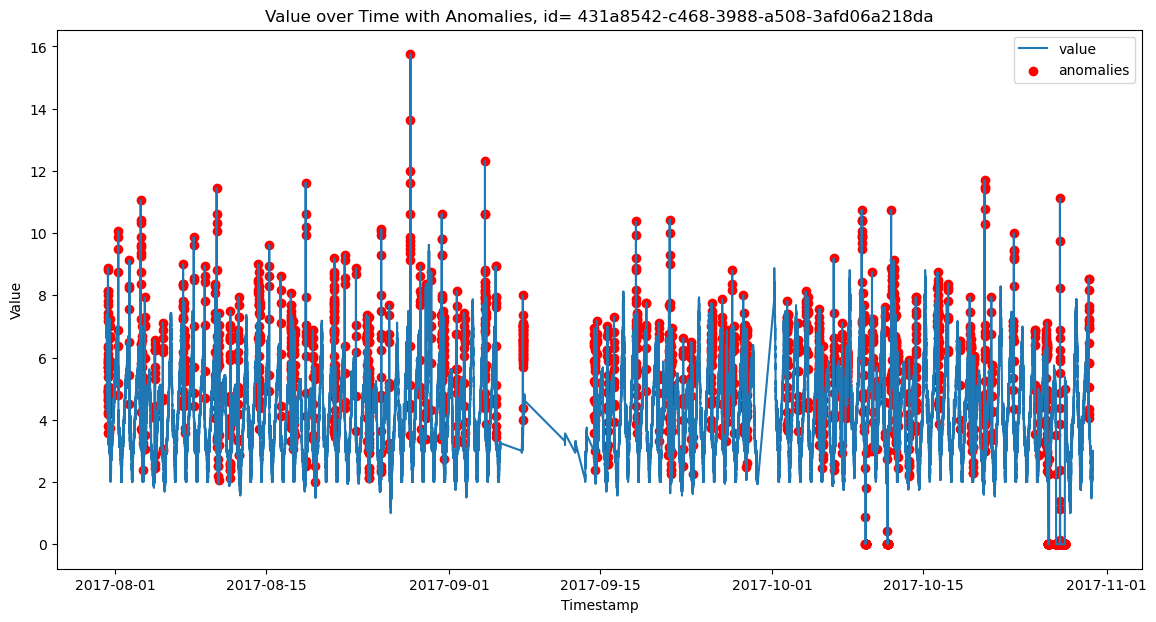

i = 1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0


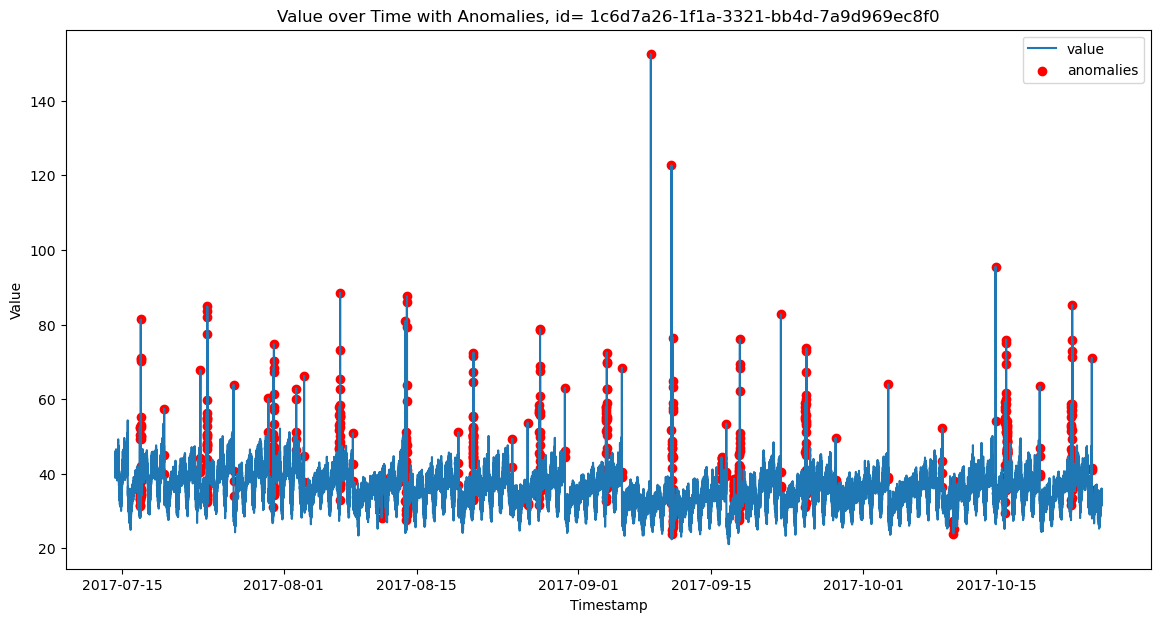

i = c69a50cf-ee03-3bd7-831e-407d36c7ee91


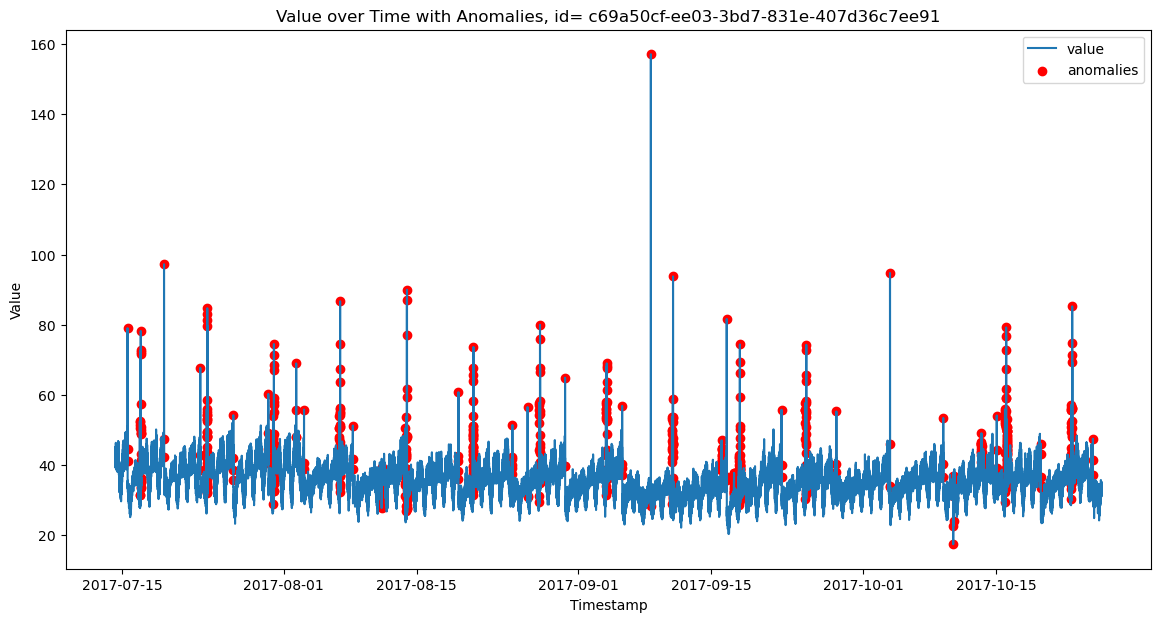

i = 05f10d3a-239c-3bef-9bdc-a2feeb0037aa


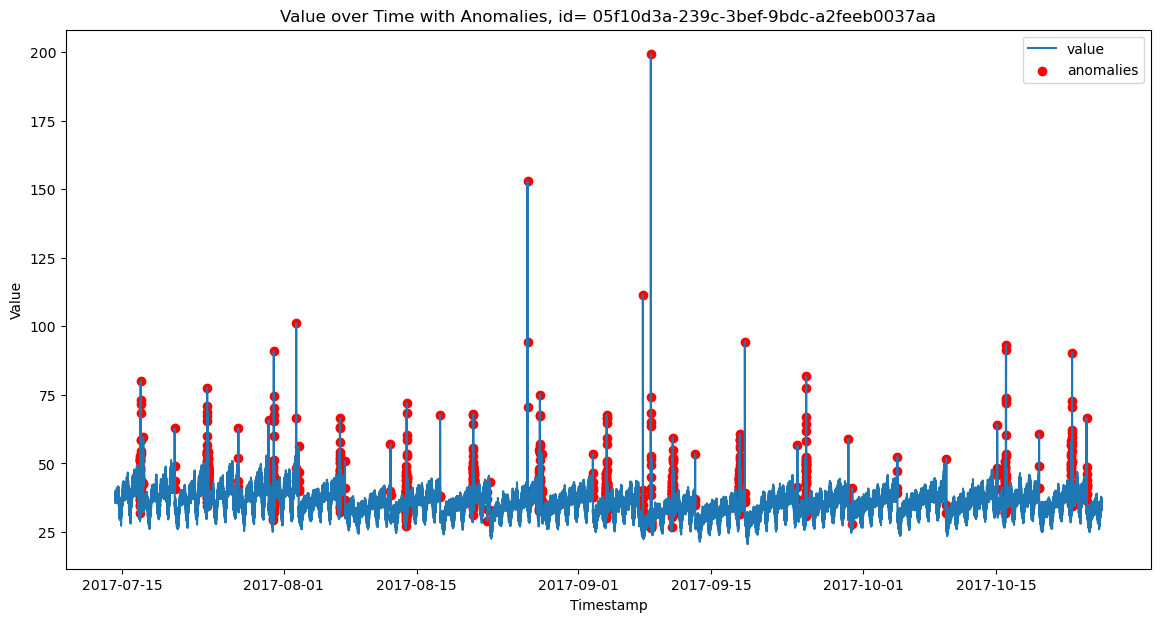

i = 847e8ecc-f8d2-3a93-9107-f367a0aab37d


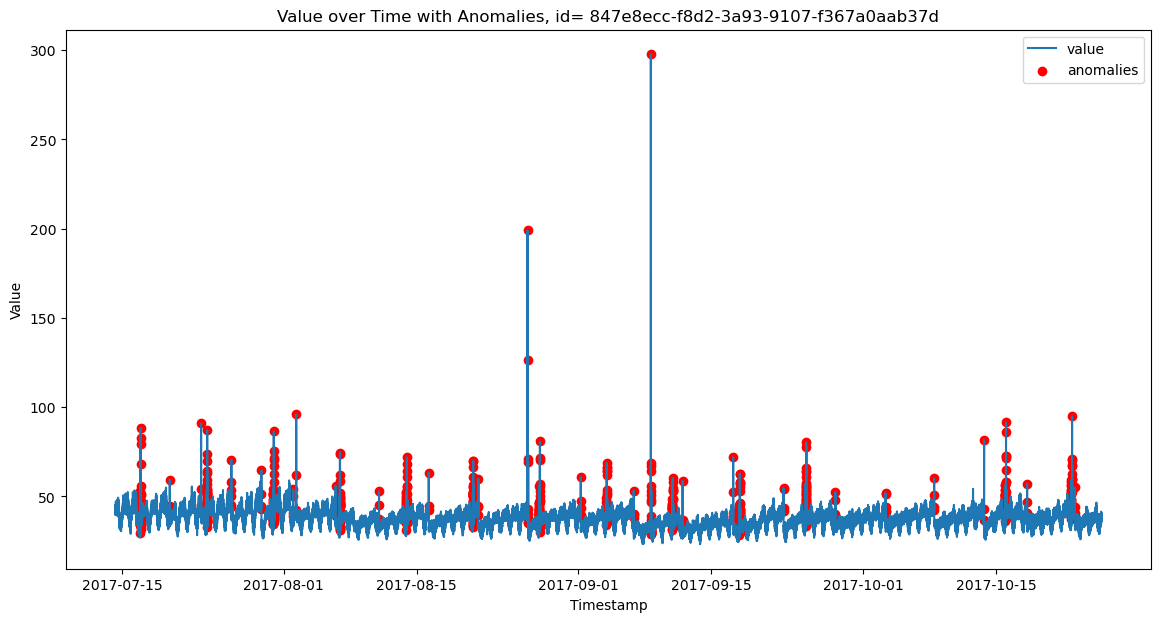

i = 6efa3a07-4544-34a0-b921-a155bd1a05e8


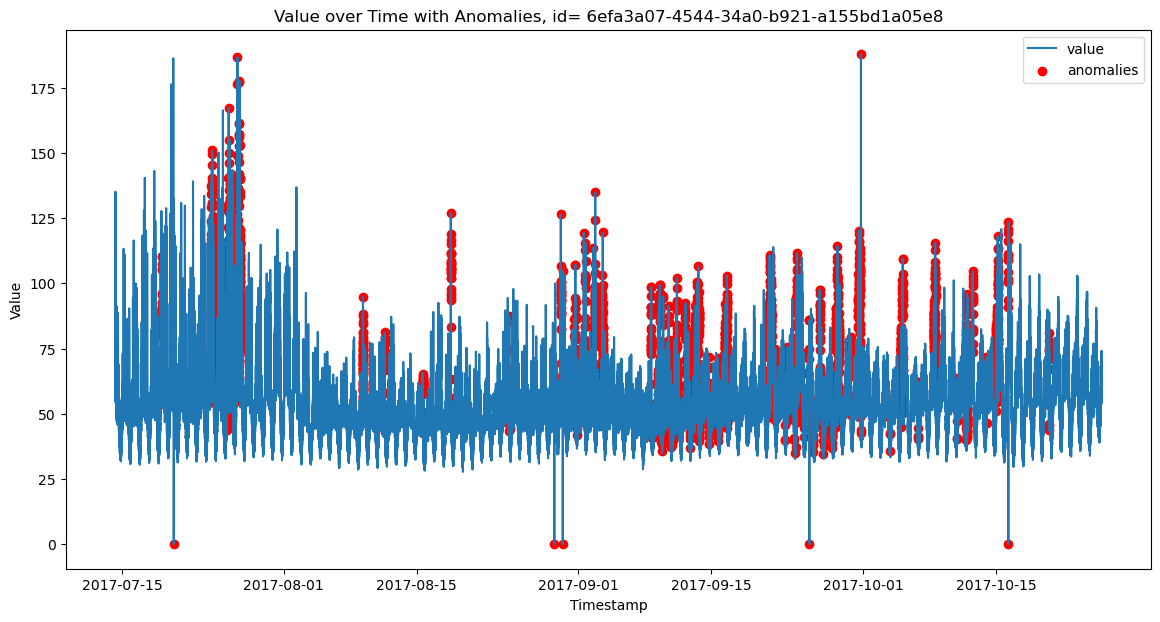

i = 43115f2a-baeb-3b01-96f7-4ea14188343c


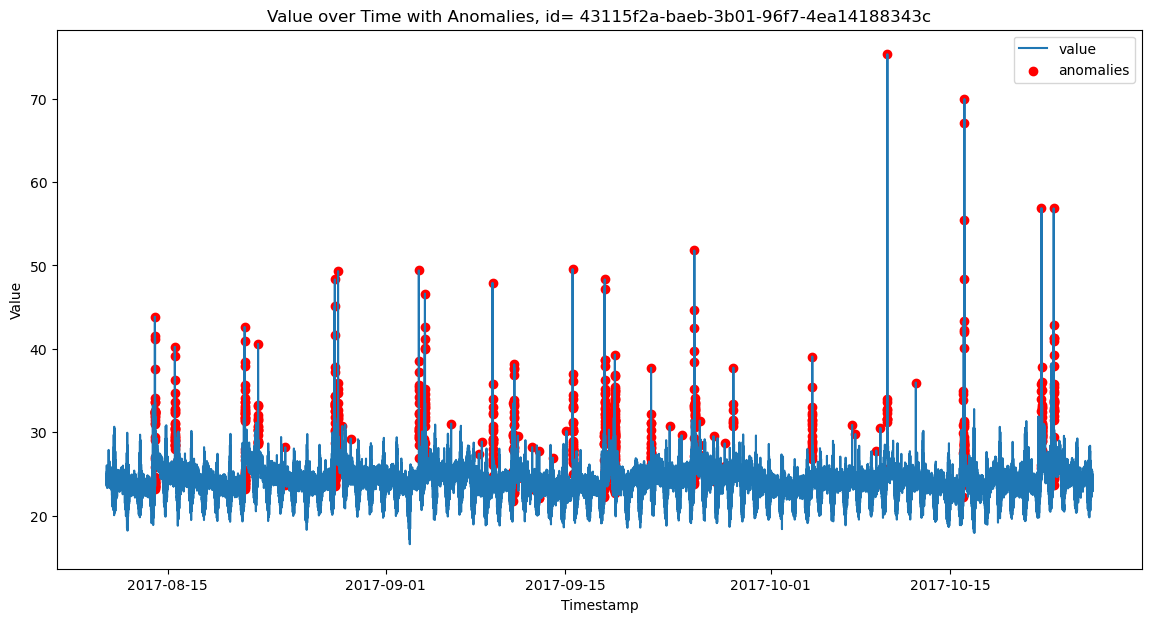

i = 9c639a46-34c8-39bc-aaf0-9144b37adfc8


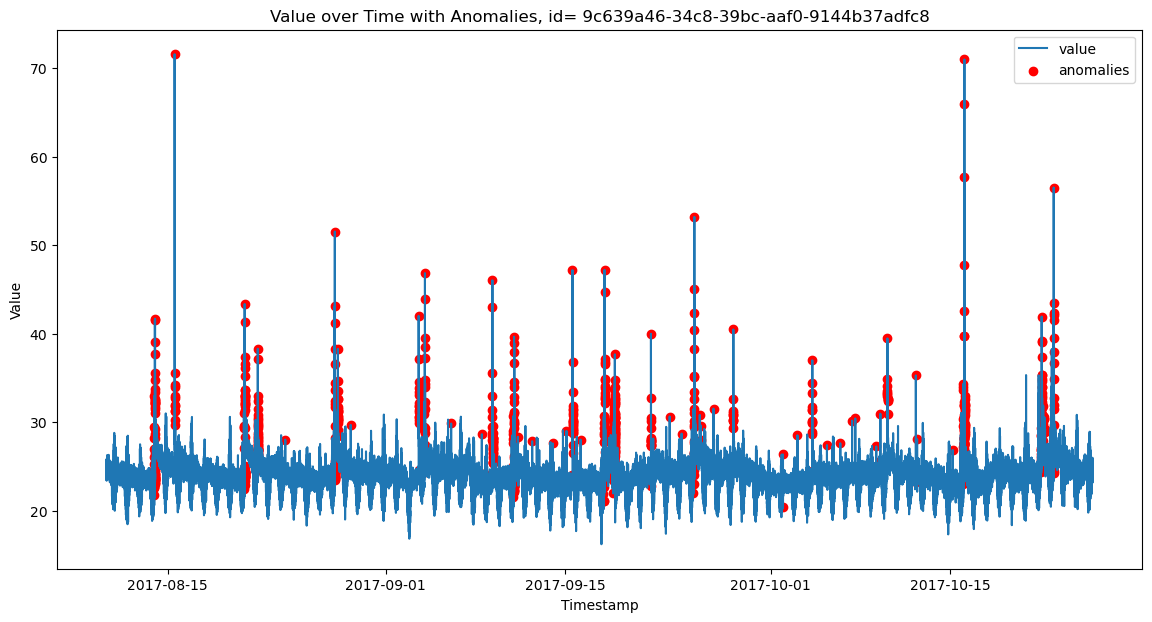

i = a07ac296-de40-3a7c-8df3-91f642cc14d0


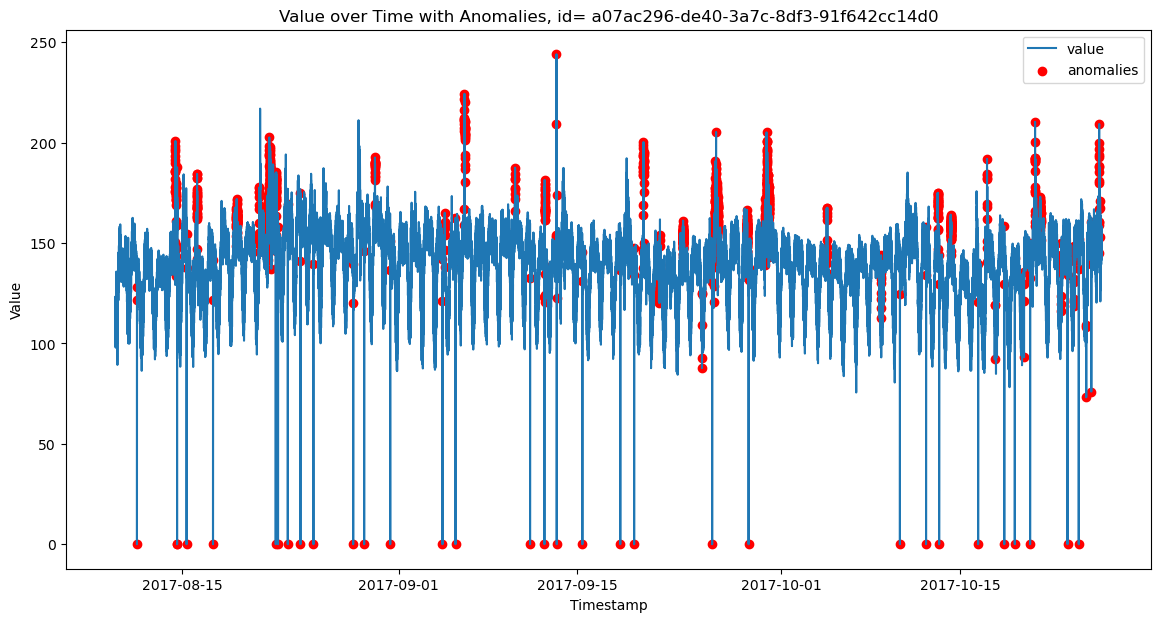

i = ba5f3328-9f3f-3ff5-a683-84437d16d554


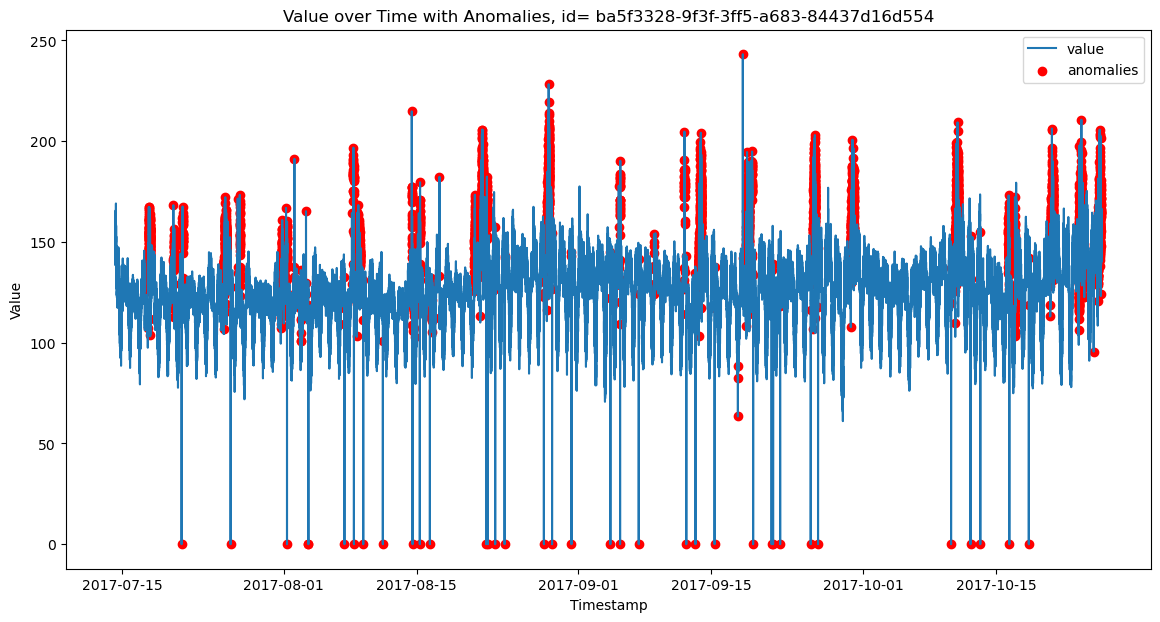

i = 55f8b8b8-b659-38df-b3df-e4a5a8a54bc9


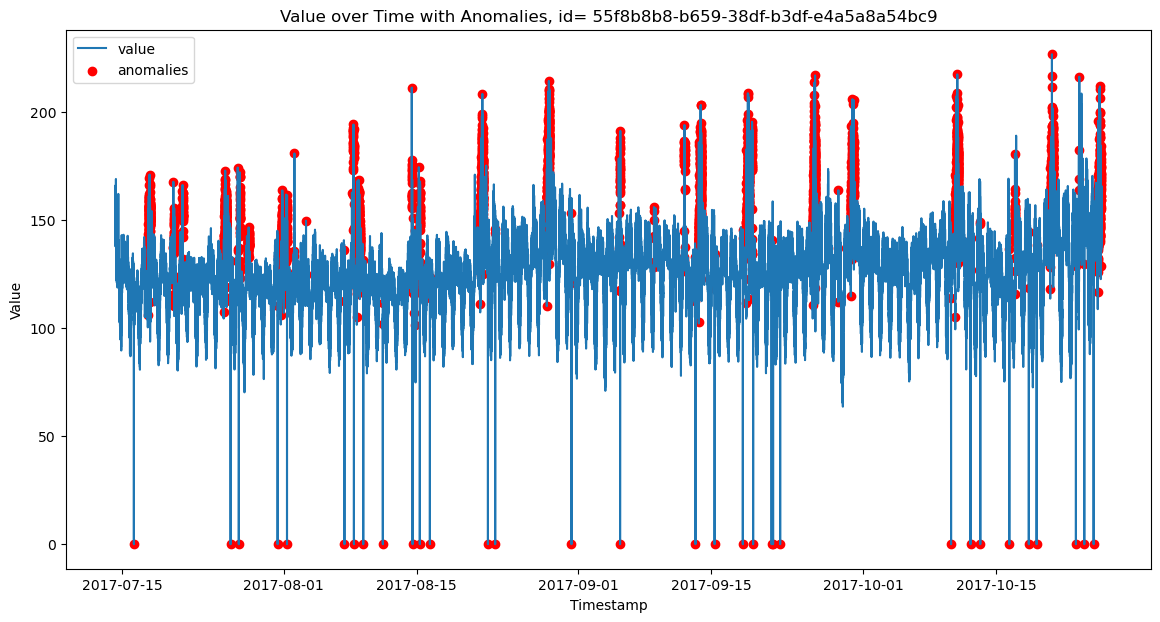

i = 6d1114ae-be04-3c46-b5aa-be1a003a57cd


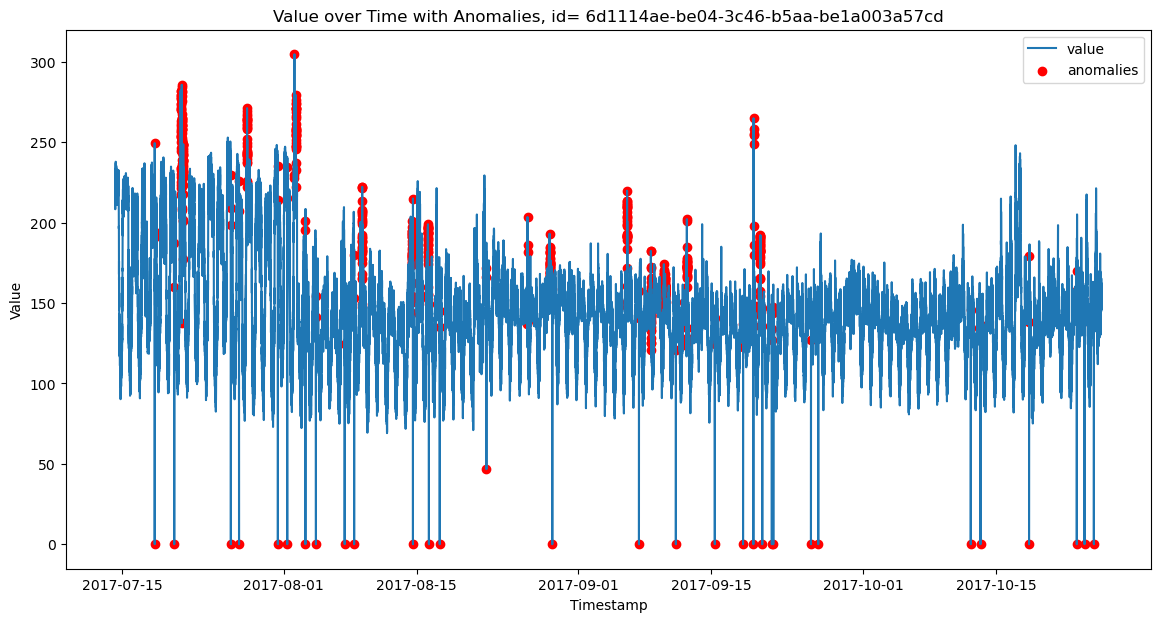

i = 8723f0fb-eaef-32e6-b372-6034c9c04b80


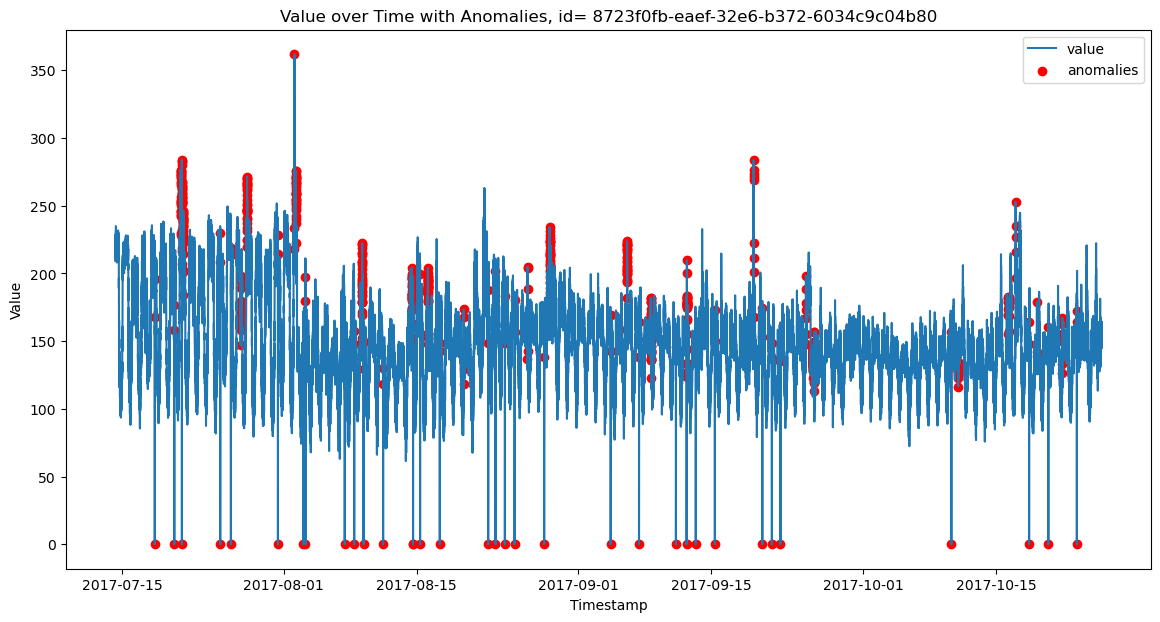

i = adb2fde9-8589-3f5b-a410-5fe14386c7af


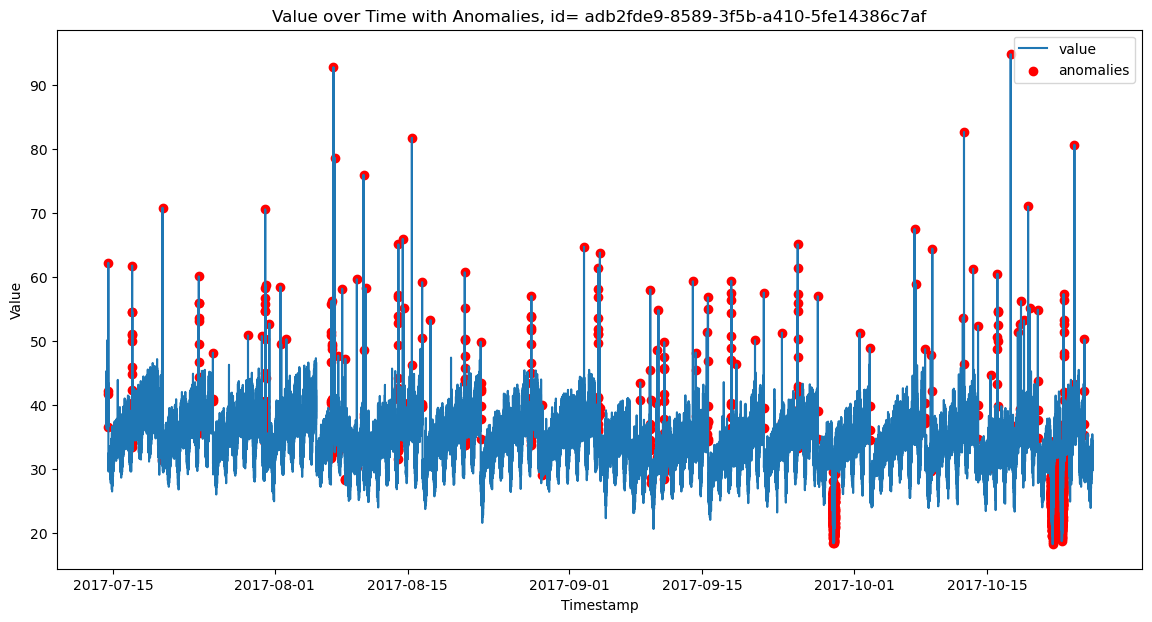

i = 42d6616d-c9c5-370a-a8ba-17ead74f3114


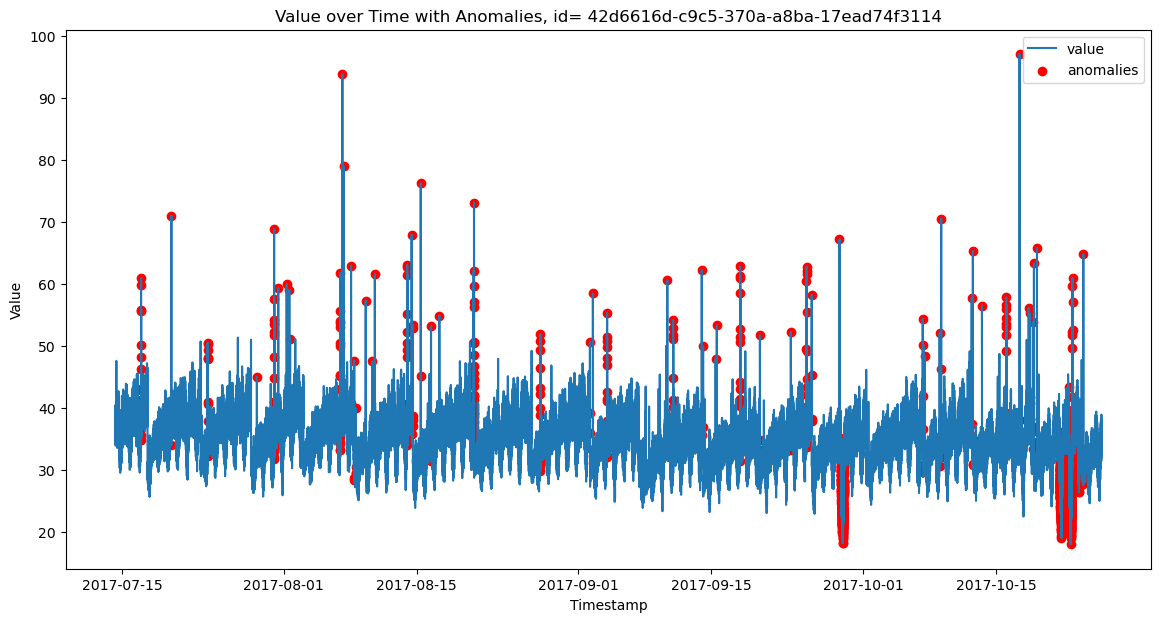

In [7]:
kpi_id = labels['KPI ID'].unique()
for i in kpi_id:
    df = labels[labels['KPI ID'] == i]
    print(f'i = {i}')
    plt.figure(figsize=(14, 7))

    # Line plot for 'value' over time
    plt.plot(df['timestamp'], df['value'], label='value')

    # Filter out the anomalous points
    anomalies = df[df['label'] == 1]

    # Plot red dots at the anomaly points
    plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='anomalies')

    plt.title(f'Value over Time with Anomalies, id= {i}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## Model selection

In this notebook we implemented four versions of common models used in anomaly detection tasks:
* LSTM 
* Auetoencoders
* One Class SVM
* Isolation Forest

## Experiment 1: 42d6616d-c9c5-370a-a8ba-17ead74f3114

Let's cut off first two months for training data ( Montecarlo using the same approach)

In [9]:
def create_train_test_part(train, labels, kpi_id):
    df_train = train[train['KPI ID'] == kpi_id]
    df_test = labels[labels['KPI ID'] == kpi_id]

    df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
    df_train.set_index('timestamp', inplace=True)
    start_date = df_train.index.min()
    end_date = start_date + pd.Timedelta(days=60)
    first_60_days_df = df_train.loc[start_date:end_date].reset_index()
    
    mask = (df_train.index >= start_date) & (df_train.index <= end_date)
    df_train_above_60_days = df_train.loc[~mask].reset_index()

    df_test = pd.concat([df_train_above_60_days, df_test], ignore_index=True)
    df_test = df_test.sort_values(by='timestamp')
    df_train = first_60_days_df
    
    return df_train, df_test

In [24]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='42d6616d-c9c5-370a-a8ba-17ead74f3114')

In [10]:
def train_test_chart(df_train, df_test):    
    plt.figure(figsize=(14, 7))
    plt.plot(df_train['timestamp'], df_train['value'], label='train', color='green')
    plt.plot(df_test['timestamp'], df_test['value'], label='test')

    anomalies_true = df_test[df_test['label'] == 1]
    plt.scatter(anomalies_true['timestamp'], anomalies_true['value'], color='red', label='anomalies')
    plt.title(f'Train - Test split with Anomalies')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

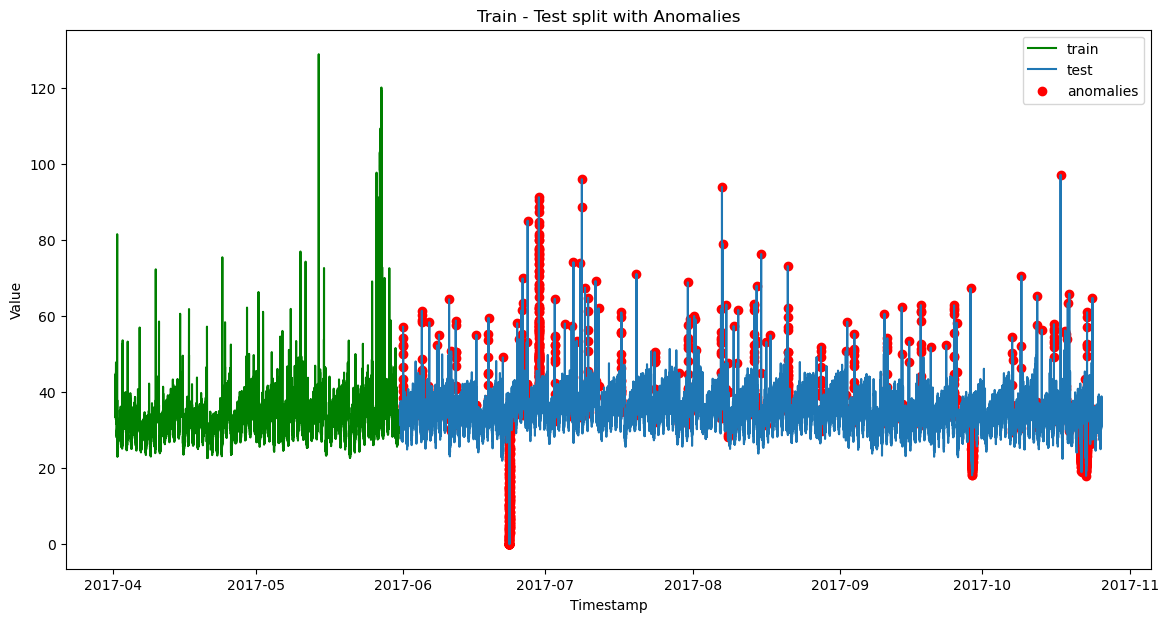

In [26]:
train_test_chart(df_train, df_test)

### LSTM

#### Creating normal data for training
To train LSTM moel we need to have data with normal behaviour. Unfortunatelly, we only have data with anomalies. Let's replace anomaly values in train part with nan and interpolate this nan values, so it will look normal.



In [13]:
def create_normal_data(df_train, df_test):
    fig, axs = plt.subplots(2, 1, figsize=(11, 11))
    
    # desplay the data we originally have
    anomalies_in_train = pd.concat([df_train, df_test])

    axs[0].plot(anomalies_in_train['timestamp'], anomalies_in_train['value'], label='value')
    anomalies = anomalies_in_train[anomalies_in_train['label'] == 1]
    axs[0].scatter(anomalies['timestamp'], anomalies['value'], color='red', label='anomalies')
    axs[0].set_title(f'Value over Time with Anomalies')
    axs[0].set_xlabel('Timestamp')
    axs[0].set_ylabel('Value')
    axs[0].legend()

    
    # desplay the data with removed anomalies from training part
    df_train.loc[df_train['label'] == 1, 'value'] = np.nan
    df_train['value'] = df_train['value'].interpolate()
    df_train['label'] = 0
    no_anomalie_in_train = pd.concat([df_train, df_test])

    axs[1].plot(no_anomalie_in_train['timestamp'], no_anomalie_in_train['value'], label='value')
    anomalies = df_test[df_test['label'] == 1]
    axs[1].scatter(anomalies['timestamp'], anomalies['value'], color='red', label='anomalies')
    axs[1].set_title(f'Value over Time with Anomalies and interpolated train part')
    axs[1].set_xlabel('Timestamp')
    axs[1].set_ylabel('Value')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
    return no_anomalie_in_train

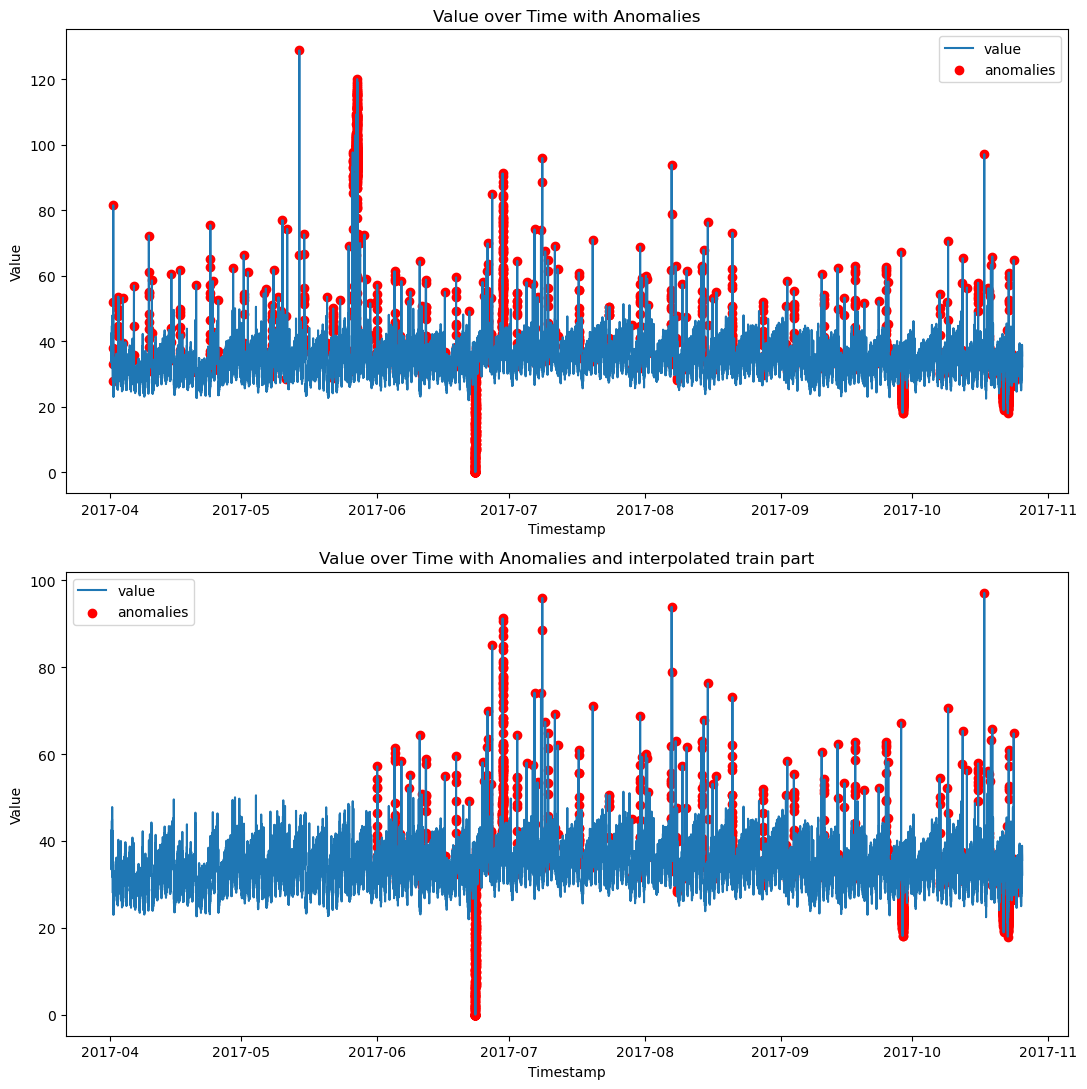

In [28]:
df_train = create_normal_data(df_train, df_test)

#### Model training

In [11]:
def samples_supervised(s, n_window, forecast_steps_ahead): 
    x, y = [], []
    for i in range(n_window, len(s) - forecast_steps_ahead + 1):
        t_start = i - n_window
        t_end = i
        
        x_t = s[t_start:t_end]        
        y_t = s[t_end + forecast_steps_ahead - 1]
            
        x.append(x_t)
        y.append(y_t)
    
    # Reshape x to be 3D [samples, timesteps, features]
    return np.stack(x)[:,:,np.newaxis], np.array(y)

In [12]:
def train_test_split(x, y, train_ratio):
    t = int(len(x)*train_ratio)
    return x[0:t], y[0:t], x[t:], y[t:]

In [13]:
def build_lstm_model(df_train, n_window, forecast_steps_ahead, train_ratio):
    from keras import backend as K
    K.clear_session()
    
    x, y = samples_supervised(df_train['value'].values, n_window, forecast_steps_ahead)
    print("x shape:", x.shape)
    print("y shape:", y.shape)
    x_train, y_train, x_test, y_test = train_test_split(x, y, train_ratio)
    
    print(f'Train tensor shape {x_train.shape}')
    print(f'Test tensor shape {x_test.shape}')

    n_samples = x_train.shape[0]

    tf.keras.backend.set_image_data_format("channels_last")

    input_model = layers.Input(shape=(n_window, 1))
    layer_lstm = layers.LSTM(hidden_units)(input_model)
    layer_dropout = layers.Dropout(rate=0.1)(layer_lstm)
    output_dense = layers.Dense(1, activation='linear')(layer_dropout)
    model_lstm = models.Model(inputs=input_model, outputs=output_dense)

    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    model_lstm.compile(loss='mean_squared_error',  optimizer='adam')
    model_lstm.summary()
    model_lstm.fit(x_train, 
                   y_train, 
                   epochs=10, 
                   batch_size=4, 
                   validation_data=(x_test, y_test), 
                   use_multiprocessing=True, 
                   verbose=1)
    score = model_lstm.evaluate(x_test, y_test, verbose=0) 
    print('Test MSE:', score) 
    
    return model_lstm

In [ ]:
# dataset parameters
n_window = 80            # input window
forecast_steps_ahead = 5  # forecasting horizon
train_ratio = 0.8

# model parameters
hidden_units = 4          # LSTM state dimensionality

model_lstm = build_lstm_model(df_train, n_window, forecast_steps_ahead, train_ratio)

x shape: (295330, 80, 1)
y shape: (295330,)
Train tensor shape (236264, 80, 1)
Test tensor shape (59066, 80, 1)


2023-07-18 11:47:02.416936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
59066/59066 [==============================] - 869s 15ms/step - loss: 76.8954 - val_loss: 3.6001
Epoch 2/10
59066/59066 [==============================] - 874s 15ms/step - loss: 6.1252

#### Model evaluation

In [14]:
def model_evaluation(df_test, model_lstm):
    test_dataset = df_test['value'].values
    x = samples_supervised(test_dataset, n_window, forecast_steps_ahead)[0]
    y = test_dataset[n_window+forecast_steps_ahead-1:]
    
    y_hat = model_lstm.predict(x).T[0]
    
    evaluation_dataset = df_test.iloc[n_window+forecast_steps_ahead-1:]
    evaluation_dataset['predicted'] = y_hat
    
    se = np.square(y - y_hat)
    evaluation_dataset['se'] = se
    
    return evaluation_dataset

In [30]:
evaluation_dataset = model_evaluation(df_test, model_lstm)

6566/6566 [==============================] - 36s 5ms/step


#### Threshold optimization

In [15]:
def find_threshold(df):
    from sklearn.metrics import f1_score

    def objective(trial):
        # Adjust the range as per your requirements
        threshold = trial.suggest_uniform('threshold', df['se'].min(), df['se'].max())

        # Apply the threshold for anomaly detection
        df['label_predicted'] = np.where(df['se'] > threshold, 1, 0)

        # Calculate the F1-score
        f1 = f1_score(df['label'], df['label_predicted'])
        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_threshold = study.best_params['threshold']

    # Apply the best threshold for anomaly detection
    df['label_predicted'] = np.where(df['se'] > best_threshold, 1, 0)
    
    return df, best_threshold

In [35]:
evaluation_dataset, best_threshold = find_threshold(evaluation_dataset)

[I 2023-07-18 14:15:40,668] A new study created in memory with name: no-name-76f2a59b-9c8b-4349-946e-199364e306de
[I 2023-07-18 14:15:40,734] Trial 0 finished with value: 0.2197505898213684 and parameters: {'threshold': 59.43155483810971}. Best is trial 0 with value: 0.2197505898213684.
[I 2023-07-18 14:15:40,799] Trial 1 finished with value: 0.19741890477851412 and parameters: {'threshold': 77.06826609406332}. Best is trial 0 with value: 0.2197505898213684.
[I 2023-07-18 14:15:40,859] Trial 2 finished with value: 0.186062964273081 and parameters: {'threshold': 94.8910033297956}. Best is trial 0 with value: 0.2197505898213684.
[I 2023-07-18 14:15:40,924] Trial 3 finished with value: 0.08379668632406627 and parameters: {'threshold': 10.415223498239035}. Best is trial 0 with value: 0.2197505898213684.
[I 2023-07-18 14:15:40,985] Trial 4 finished with value: 0.20875718708536045 and parameters: {'threshold': 27.225866473259973}. Best is trial 0 with value: 0.2197505898213684.
[I 2023-07-18

#### Model evaluation results

In [16]:
def evaluation_chart(df):
    plt.figure(figsize=(14, 7))
    
    plt.plot(df['timestamp'], df['value'], label='Observed')
    plt.plot(df['timestamp'], df['predicted'], label=f'Forecast')
    anomalies_true = df[df['label'] == 1]
    plt.scatter(anomalies_true['timestamp'], anomalies_true['value'], color='red', label='true anomalies')
    anomalies_pred = df[df['label_predicted'] == 1]
    plt.scatter(anomalies_pred['timestamp'], anomalies_pred['value'], color='green', label='predicted anomalies')
    plt.legend()
    plt.show()

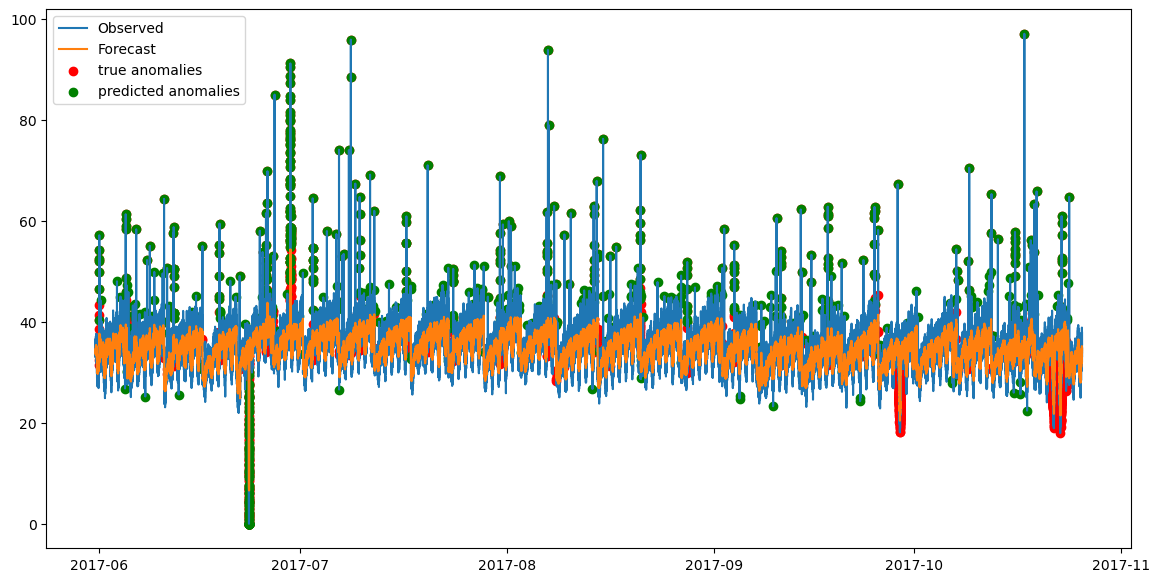

In [37]:
evaluation_chart(evaluation_dataset)

In [39]:
print(classification_report(evaluation_dataset['label'], evaluation_dataset['label_predicted']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    207587
           1       0.55      0.16      0.25      2519

    accuracy                           0.99    210106
   macro avg       0.77      0.58      0.62    210106
weighted avg       0.98      0.99      0.99    210106



In [40]:
model_lstm.save('models/lstm_model_window80_train60_test1.h5')

### One Class SVM

#### Prepare dataset

In [82]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='42d6616d-c9c5-370a-a8ba-17ead74f3114')

In [83]:
df_train

timestamp  value  label                                KPI ID
0     2017-04-01 10:08:00  35.11      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
1     2017-04-01 10:09:00  35.67      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
2     2017-04-01 10:10:00  34.34      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
3     2017-04-01 10:11:00  36.54      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
4     2017-04-01 10:12:00  36.06      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
...                   ...    ...    ...                                   ...
85219 2017-05-31 10:04:00  33.21      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
85220 2017-05-31 10:05:00  32.25      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
85221 2017-05-31 10:06:00  33.41      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
85222 2017-05-31 10:07:00  33.88      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
85223 2017-05-31 10:08:00  34.97      0  42d6616d-c9c5-370a-a8ba-17ead74f3114

[85224 rows x 4 columns]

#### Model training

In [84]:
nu  = df_train['label'].sum() / df_train.shape[0]

model = OneClassSVM(kernel = 'rbf', gamma = 0.01, nu = nu).fit(
    pd.DataFrame(df_train['value']))

In [85]:
nu

0.009199286585938233

#### Model evaluation results

In [86]:
y_pred = model.predict(pd.DataFrame(df_test['value']))
df_test['label_predicted'] = y_pred
#repllace anomaly labels since sklearn returns -1 for anomalies and 1 for normal points
df_test['label_predicted'] = df_test['label_predicted'].replace({1: 0, -1: 1})

In [21]:
def evaluation_chart_sklearn(df):
    plt.figure(figsize=(14, 7))
    
    plt.plot(df['timestamp'], df['value'], label='Observed')
    anomalies_true = df[df['label'] == 1]
    plt.scatter(anomalies_true['timestamp'], anomalies_true['value'], color='red', label='true anomalies')
    anomalies_pred = df[df['label_predicted'] == 1]
    plt.scatter(anomalies_pred['timestamp'], anomalies_pred['value'], color='green', label='predicted anomalies')
    plt.legend()
    plt.show()

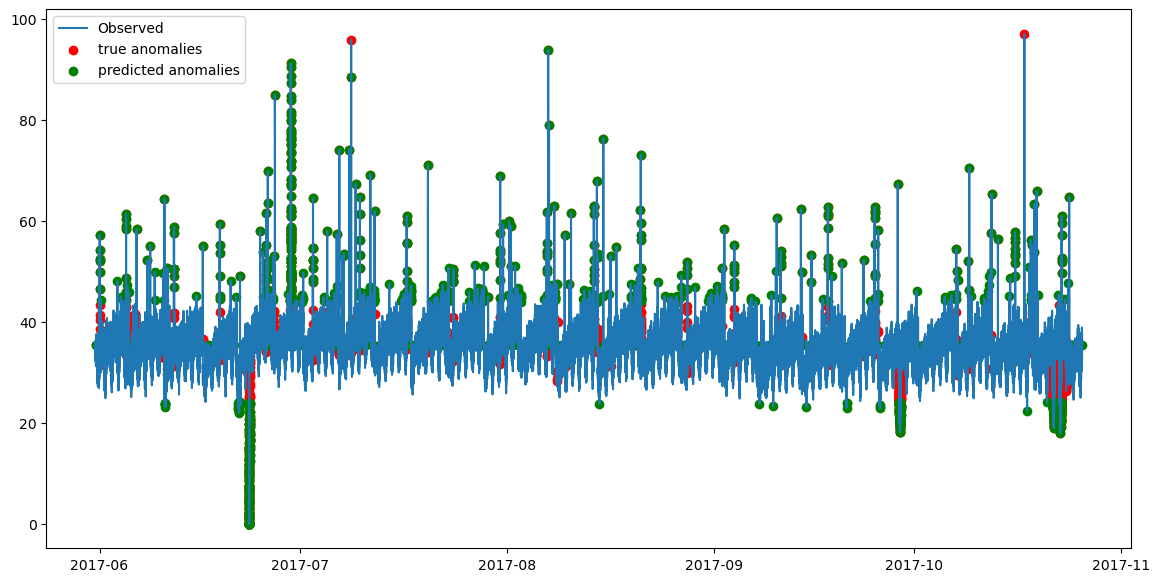

In [88]:
evaluation_chart_sklearn(df_test)

In [89]:
print(classification_report(df_test['label'], df_test['label_predicted']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    207671
           1       0.31      0.36      0.33      2519

    accuracy                           0.98    210190
   macro avg       0.65      0.68      0.66    210190
weighted avg       0.98      0.98      0.98    210190



### Isolation Forest

#### Prepare dataset

In [90]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='42d6616d-c9c5-370a-a8ba-17ead74f3114')

#### Model training

In [91]:
contamination = df_train['label'].sum() / df_train.shape[0]

model = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
model.fit(pd.DataFrame(df_train['value']))

IsolationForest(contamination=0.009199286585938233, random_state=42)

#### Model evaluation results

In [92]:
y_pred = model.predict(pd.DataFrame(df_test['value']))
df_test['label_predicted'] = y_pred
#repllace anomaly labels since sklearn returns -1 for anomalies and 1 for normal points
df_test['label_predicted'] = df_test['label_predicted'].replace({1: 0, -1: 1})

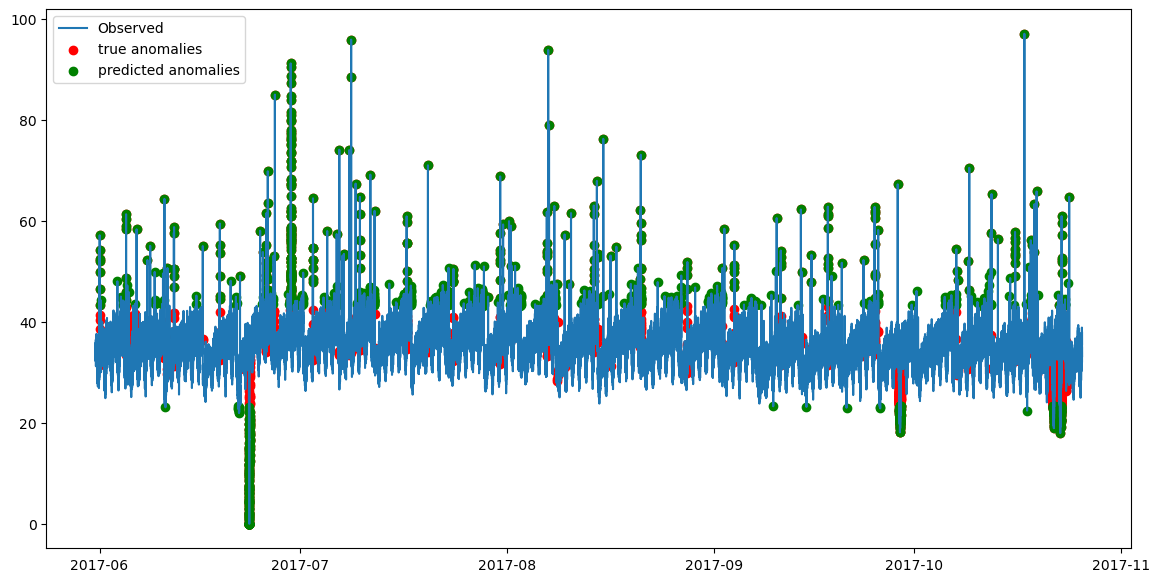

In [93]:
evaluation_chart_sklearn(df_test)

In [94]:
print(classification_report(df_test['label'], df_test['label_predicted']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    207671
           1       0.47      0.32      0.38      2519

    accuracy                           0.99    210190
   macro avg       0.73      0.66      0.69    210190
weighted avg       0.99      0.99      0.99    210190



# Experiment 2: Train and Test model with only contextual anomalies
**KPI ID**: 301c70d8-1630-35ac-8f96-bc1b6f4359ea

### LSTM

#### Dataset preparation

In [95]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='301c70d8-1630-35ac-8f96-bc1b6f4359ea')

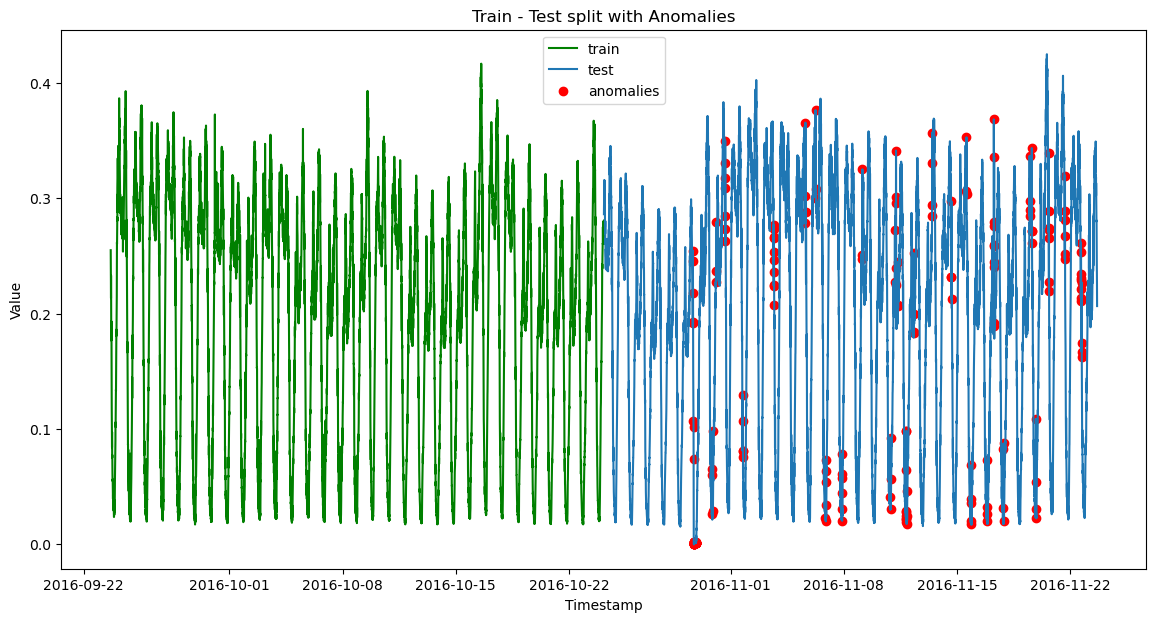

In [96]:
train_test_chart(df_train, df_test)

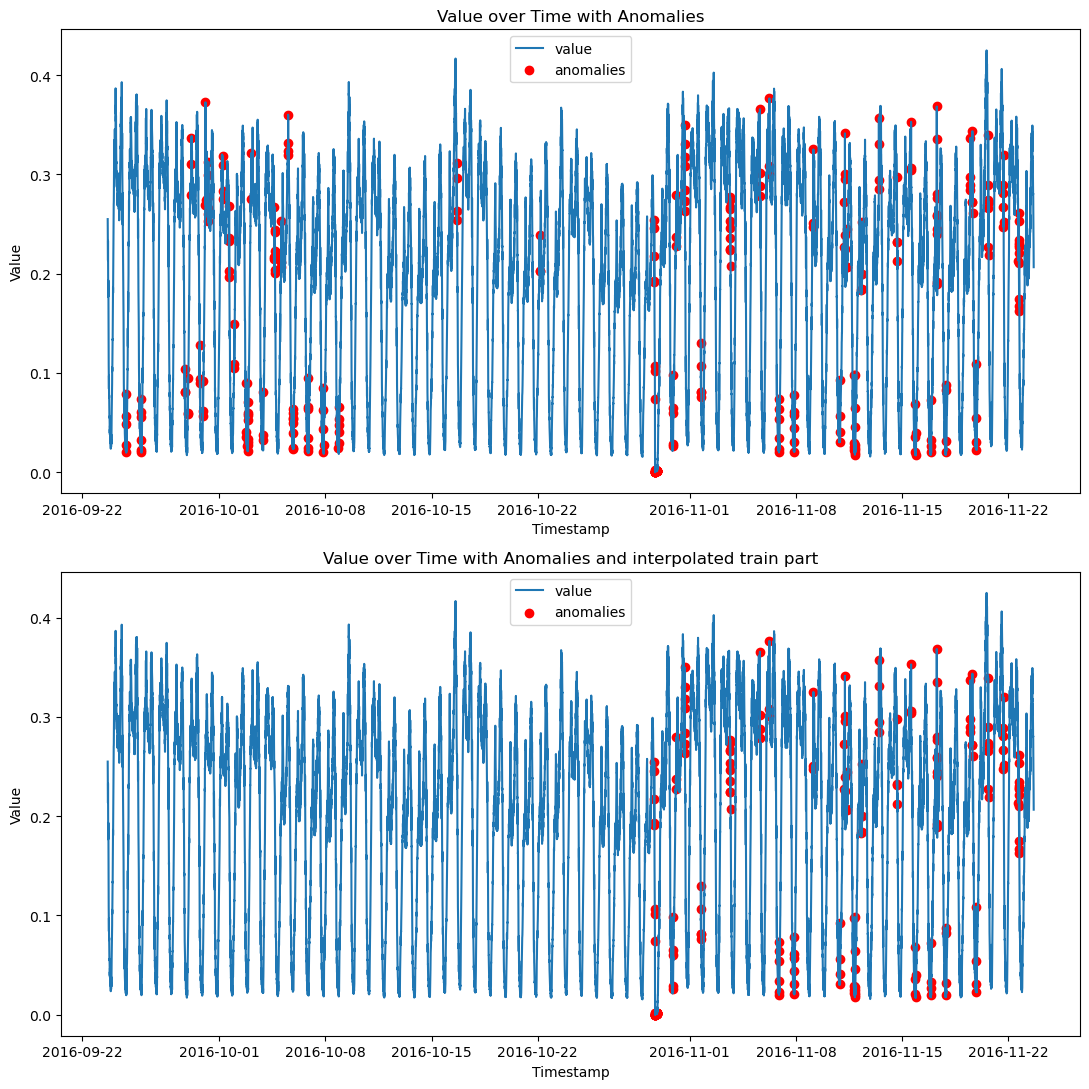

In [97]:
df_train = create_normal_data(df_train, df_test)

#### Model training

In [98]:
# dataset parameters
n_window = 80            # input window
forecast_steps_ahead = 5  # forecasting horizon
train_ratio = 0.8

# model parameters
hidden_units = 4          # LSTM state dimensionality

model_lstm = build_lstm_model(df_train, n_window, forecast_steps_ahead, train_ratio)

x shape: (17484, 80, 1)
y shape: (17484,)
Train tensor shape (13987, 80, 1)
Test tensor shape (3497, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3497/3497 [==============================] - 84s 24ms/step - loss: 0.0014 - 

#### Model evaluation

In [99]:
evaluation_dataset = model_evaluation(df_test, model_lstm)

272/272 [==============================] - 2s 5ms/step


#### Threshold optimization

In [100]:
evaluation_dataset, best_threshold = find_threshold(evaluation_dataset)

[I 2023-07-18 14:54:55,887] A new study created in memory with name: no-name-1c092291-0331-4f93-a8a8-40de8637ba39
[I 2023-07-18 14:54:55,897] Trial 0 finished with value: 0.06222222222222222 and parameters: {'threshold': 0.007100676087875512}. Best is trial 0 with value: 0.06222222222222222.
[I 2023-07-18 14:54:55,902] Trial 1 finished with value: 0.00966183574879227 and parameters: {'threshold': 0.03075356125381028}. Best is trial 0 with value: 0.06222222222222222.
[I 2023-07-18 14:54:55,908] Trial 2 finished with value: 0.00966183574879227 and parameters: {'threshold': 0.035681504874733046}. Best is trial 0 with value: 0.06222222222222222.
[I 2023-07-18 14:54:55,913] Trial 3 finished with value: 0.00966183574879227 and parameters: {'threshold': 0.02786030151920866}. Best is trial 0 with value: 0.06222222222222222.
[I 2023-07-18 14:54:55,919] Trial 4 finished with value: 0.00966183574879227 and parameters: {'threshold': 0.029889679918396594}. Best is trial 0 with value: 0.062222222222

In [101]:
best_threshold

0.0026165386561994917

#### Model evaluation results

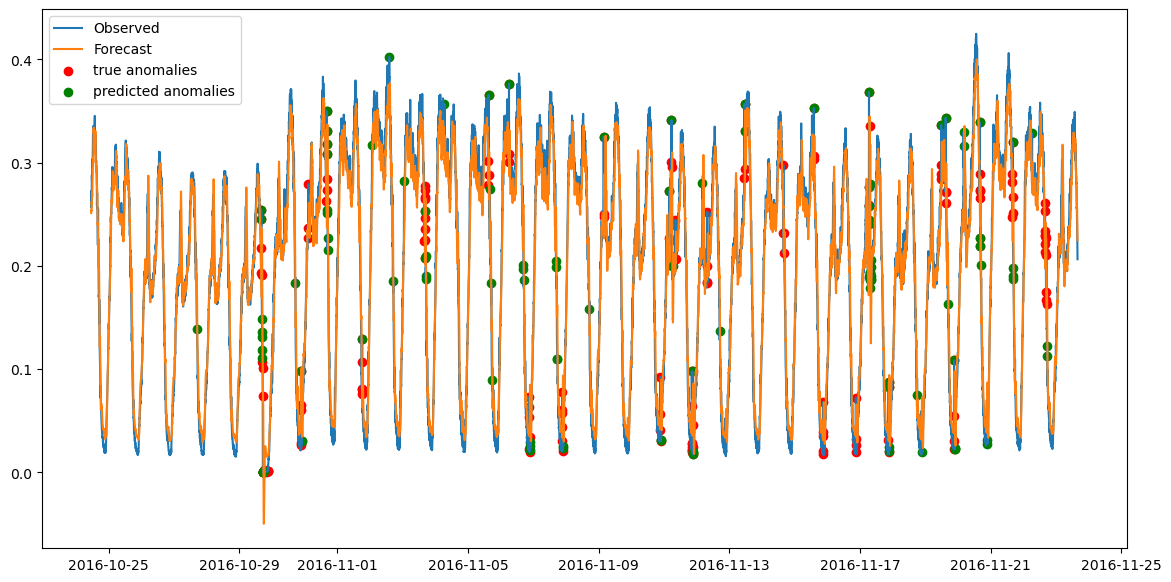

In [102]:
evaluation_chart(evaluation_dataset)

In [103]:
print(classification_report(evaluation_dataset['label'], evaluation_dataset['label_predicted']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8494
           1       0.35      0.20      0.25       206

    accuracy                           0.97      8700
   macro avg       0.66      0.59      0.62      8700
weighted avg       0.97      0.97      0.97      8700



In [108]:
model_lstm.save('models/lstm_model_window80_train60_test2.h5')

### One Class SVM

#### Prepare dataset

In [104]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='42d6616d-c9c5-370a-a8ba-17ead74f3114')

#### Model training

In [106]:
nu  = df_train['label'].sum() / df_train.shape[0]

model = OneClassSVM(kernel = 'rbf', gamma = 0.01, nu = nu).fit(
    pd.DataFrame(df_train['value']))

#### Model evaluation results

In [109]:
y_pred = model.predict(pd.DataFrame(df_test['value']))
df_test['label_predicted'] = y_pred
#repllace anomaly labels since sklearn returns -1 for anomalies and 1 for normal points
df_test['label_predicted'] = df_test['label_predicted'].replace({1: 0, -1: 1})

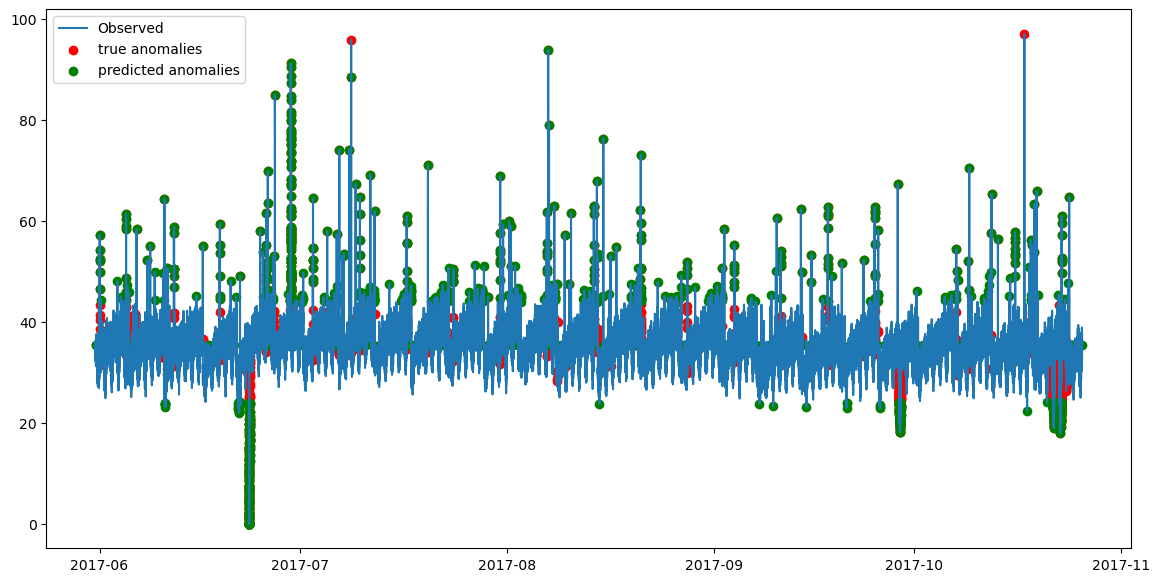

In [110]:
evaluation_chart_sklearn(df_test)

In [111]:
print(classification_report(df_test['label'], df_test['label_predicted']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    207671
           1       0.31      0.36      0.33      2519

    accuracy                           0.98    210190
   macro avg       0.65      0.68      0.66    210190
weighted avg       0.98      0.98      0.98    210190



### Isolation Forest

#### Prepare dataset

In [112]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='42d6616d-c9c5-370a-a8ba-17ead74f3114')

#### Model training

In [113]:
contamination = df_train['label'].sum() / df_train.shape[0]

model = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
model.fit(pd.DataFrame(df_train['value']))

IsolationForest(contamination=0.009199286585938233, random_state=42)

#### Model evaluation results

In [114]:
y_pred = model.predict(pd.DataFrame(df_test['value']))
df_test['label_predicted'] = y_pred
#repllace anomaly labels since sklearn returns -1 for anomalies and 1 for normal points
df_test['label_predicted'] = df_test['label_predicted'].replace({1: 0, -1: 1})

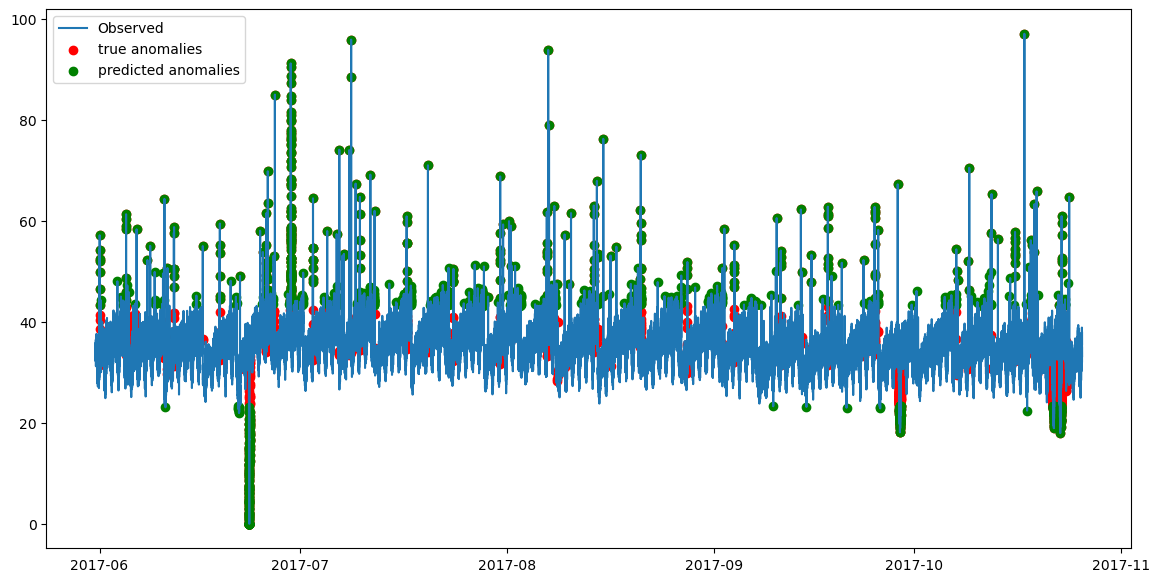

In [115]:
evaluation_chart_sklearn(df_test)

In [116]:
print(classification_report(df_test['label'], df_test['label_predicted']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    207671
           1       0.47      0.32      0.38      2519

    accuracy                           0.99    210190
   macro avg       0.73      0.66      0.69    210190
weighted avg       0.99      0.99      0.99    210190



# Experiment 3: f0932edd-6400-3e63-9559-0a9860a1baa9

### LSTM

#### Dataset preparation

In [21]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='f0932edd-6400-3e63-9559-0a9860a1baa9')

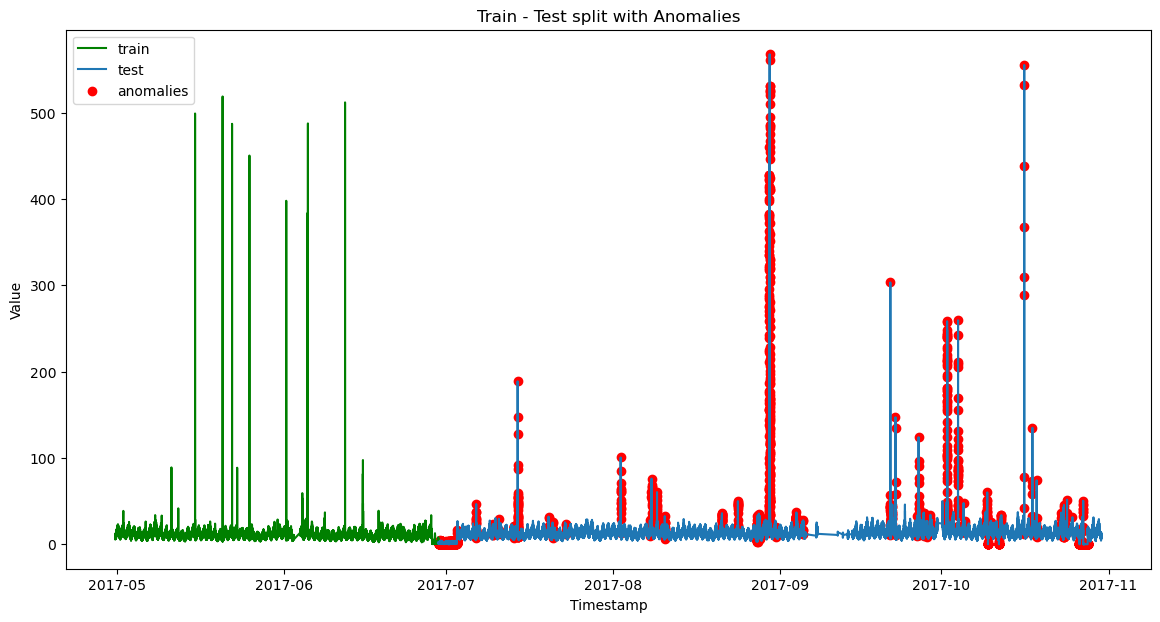

In [22]:
train_test_chart(df_train, df_test)

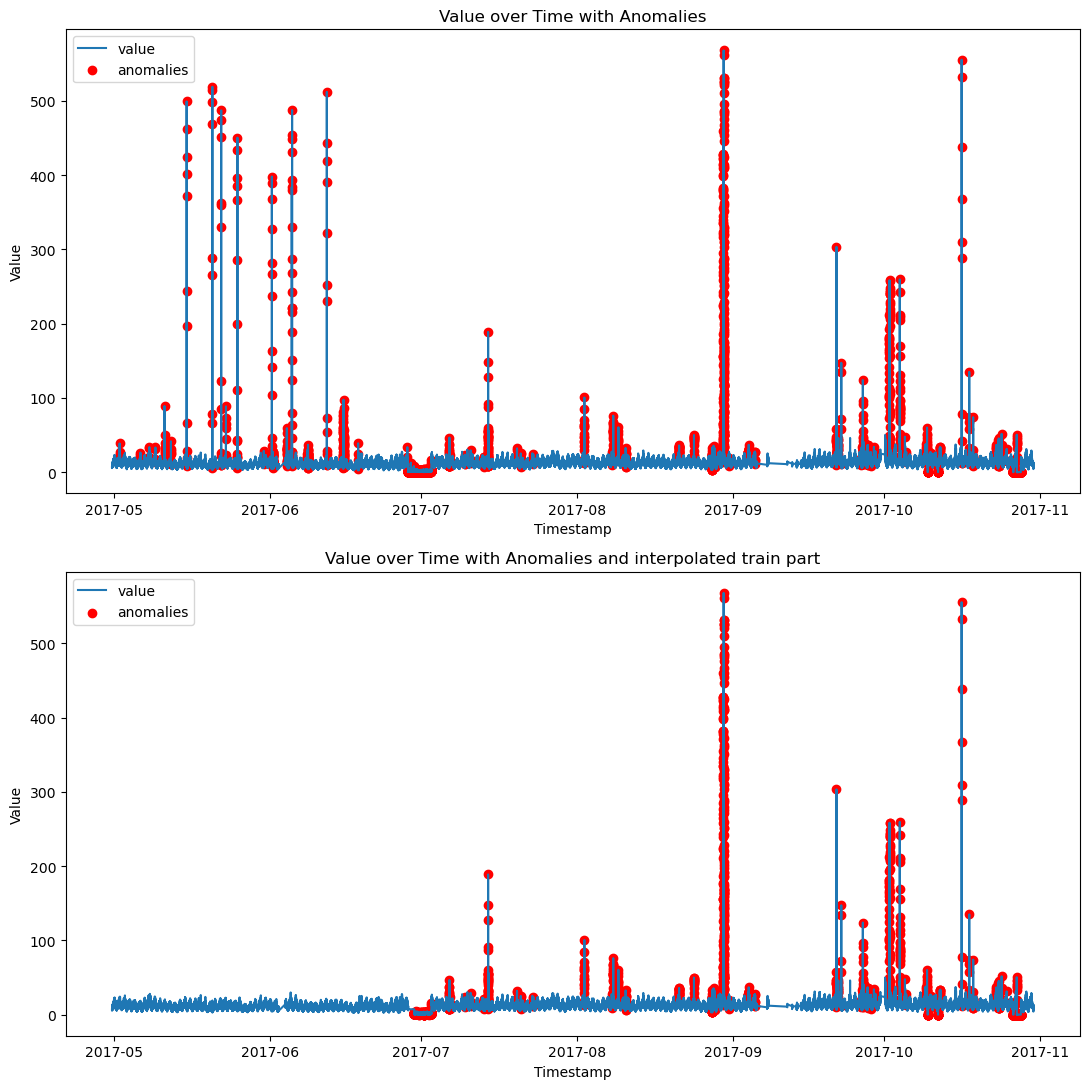

In [23]:
df_train = create_normal_data(df_train, df_test)

#### Model training

In [ ]:
# dataset parameters
n_window = 80            # input window
forecast_steps_ahead = 5  # forecasting horizon
train_ratio = 0.8

# model parameters
hidden_units = 4          # LSTM state dimensionality

model_lstm = build_lstm_model(df_train, n_window, forecast_steps_ahead, train_ratio)

x shape: (240854, 80, 1)
y shape: (240854,)
Train tensor shape (192683, 80, 1)
Test tensor shape (48171, 80, 1)


2023-07-19 05:35:31.503927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
48171/48171 [==============================] - 904s 19ms/step - loss: 71.1438 - val_loss: 59.8634
Epoch 2/10
48171/48171 [==============================] - 898s 19ms/step - loss: 61.92

#### Model evaluation

In [ ]:
evaluation_dataset = model_evaluation(df_test, model_lstm)

#### Threshold optimization

In [ ]:
evaluation_dataset, best_threshold = find_threshold(evaluation_dataset)

In [ ]:
best_threshold

#### Model evaluation results

In [ ]:
evaluation_chart(evaluation_dataset)

In [ ]:
print(classification_report(evaluation_dataset['label'], evaluation_dataset['label_predicted']))

In [ ]:
model_lstm.save('models/lstm_model_window80_train60_test3.h5')

### One Class SVM

#### Prepare dataset

In [17]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='f0932edd-6400-3e63-9559-0a9860a1baa9')

#### Model training

In [18]:
nu  = df_train['label'].sum() / df_train.shape[0]

model = OneClassSVM(kernel = 'rbf', gamma = 0.01, nu = nu).fit(
    pd.DataFrame(df_train['value']))

#### Model evaluation results

In [19]:
y_pred = model.predict(pd.DataFrame(df_test['value']))
df_test['label_predicted'] = y_pred
#repllace anomaly labels since sklearn returns -1 for anomalies and 1 for normal points
df_test['label_predicted'] = df_test['label_predicted'].replace({1: 0, -1: 1})

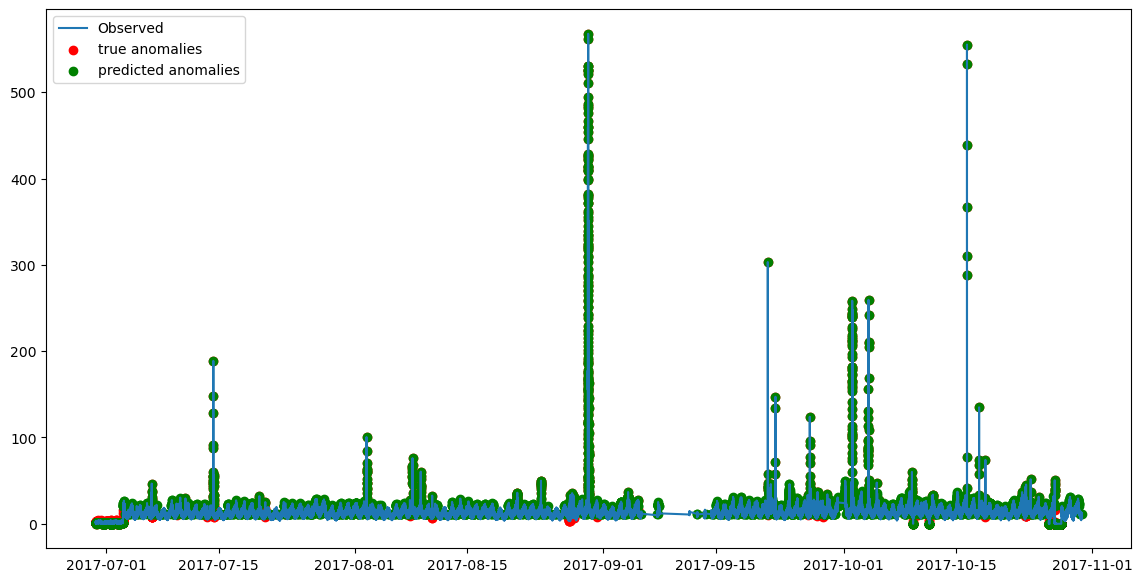

In [22]:
evaluation_chart_sklearn(df_test)

In [23]:
print(classification_report(df_test['label'], df_test['label_predicted']))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    149587
           1       0.31      0.54      0.39      7920

    accuracy                           0.92    157507
   macro avg       0.64      0.74      0.67    157507
weighted avg       0.94      0.92      0.93    157507



### Isolation Forest

#### Prepare dataset

In [24]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='f0932edd-6400-3e63-9559-0a9860a1baa9')

#### Model training

In [25]:
contamination = df_train['label'].sum() / df_train.shape[0]

model = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
model.fit(pd.DataFrame(df_train['value']))

IsolationForest(contamination=0.026081432561038464, random_state=42)

#### Model evaluation results

In [26]:
y_pred = model.predict(pd.DataFrame(df_test['value']))
df_test['label_predicted'] = y_pred
#repllace anomaly labels since sklearn returns -1 for anomalies and 1 for normal points
df_test['label_predicted'] = df_test['label_predicted'].replace({1: 0, -1: 1})

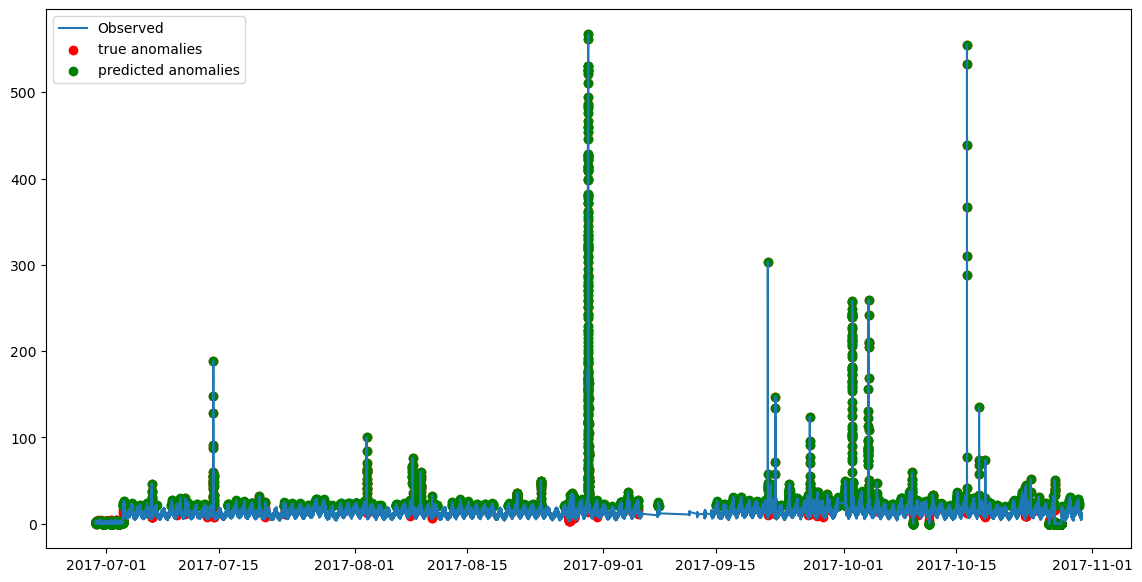

In [27]:
evaluation_chart_sklearn(df_test)

In [28]:
print(classification_report(df_test['label'], df_test['label_predicted']))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    149587
           1       0.40      0.69      0.50      7920

    accuracy                           0.93    157507
   macro avg       0.69      0.82      0.73    157507
weighted avg       0.95      0.93      0.94    157507

